Dataset and assets: https://drive.google.com/drive/folders/1y0ApxlUwMY4zBQAvF-ELJT-7sgjpKTfW?usp=sharing

In [ ]:
# Play an audio beep. Any audio URL will do.
from google.colab import output
output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

**Overview**

he concept of Market Basket Analysis (MBA) is a data mining technique that makes use of customers’ buying habits to extract useful information and insights to develop a business. Before the adoption of MBA, businesses relied heavily on hand written records, which involved a great deal of human errors and could not be analyzed for use. Provided a sufficient dataset, we were able to perform necessary data analysis to employ the three types of MBA: descriptive MBA, differential MBA, and predictive MBA. 


Descriptive MBA is widely used to rate the association between the different products using statistical techniques, which will later be used for further analysis. Additionally, differential MBA was used across data from different stores, different time of a day, days of a week, …etc. This tool is quite beneficial for exploratory data analysis where we can compare insights from different stores, or even one store and different time periods. Finally, predictive MBA was employed through a logistic regression model that predicts if a certain user will purchase a certain product in his/her current order.


Furthermore, we performed k-means clustering on the data to cluster the data into the segments needed for analysis. Customer-level segmentation involved splitting based on purchasing behavior, and common characteristics between inter-group customers. Product-level segmentation was done to segment the products into their hierarchical levels (aisles, departments, …etc.). On the other hand, FP Growth was used for association within the data, which includes sequence of purchasing for customers, the “often bought with” products for a customer, and possibly bundled products.


Segmentation and association provide a better image for the data to be in when it comes to using said data for predictions. In our case, the prediction done involves classifying a yes/no answer to the question of whether a certain user will purchase a certain product in his/her current order based on the exploratory data analysis performed on the data prior to that point. It must also be mentioned that segmentation and association serve a great role in allowing us to focus on the aspects that matter most for the prediction to take place successfully.




# 1. Prerequisites


## 1.1. Setting up Spark

In [ ]:
# install java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# install spark (change the version number if needed)
!wget -q https://archive.apache.org/dist/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz

# unzip the spark file to the current folder
!tar xf spark-3.2.1-bin-hadoop3.2.tgz

# set your spark folder to your system path environment. 
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop3.2"


# install findspark using pip
!pip install -q findspark
!pip install pyspark

In [ ]:
#importing and initializing Spark
import findspark
findspark.init()

In [ ]:
#starting a Spark session
from pyspark.sql import SparkSession

spark = SparkSession.builder\
        .master("local")\
        .appName("Colab")\
        .config('spark.ui.port', '4050')\
        .config("spark.driver.memory", "15g") \
        .getOrCreate()

In [ ]:
#printing the Spark variable to make sure it works fine
spark

## 1.2. Imports

In [ ]:
# Essentials 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from IPython.display import display
import plotly.express as px
import plotly.offline as pyo
import plotly.graph_objs as go
import networkx as nx
import json
from collections.abc import Iterable

#spark imports
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.clustering import KMeans as SKMeans
from pyspark.ml.clustering import KMeansModel
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.fpm import FPGrowth
from pyspark.sql.types import *


# Models
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

#plotting style
sns.set_style("darkgrid")
plt.rcParams['axes.axisbelow'] = True
sns.set_palette(sns.color_palette("YlGnBu", 6))

## 1.3. Constants

In [ ]:
DATA_PATH = '/content/data'

## 1.4. Extraction and Reading of Dataset

In [ ]:
!mkdir data
!cp -r /content/drive/MyDrive/bigdata_project/instacart-market-basket-analysis.zip /content
!unzip -o /content/instacart-market-basket-analysis.zip
!unzip -o /content/aisles.csv.zip -d /content/data
!unzip -o /content/departments.csv.zip -d /content/data
!unzip -o /content/order_products__prior.csv.zip -d /content/data
!unzip -o /content/order_products__train.csv.zip -d /content/data
!unzip -o /content/orders.csv.zip -d /content/data
!unzip -o /content/products.csv.zip -d /content/data


mkdir: cannot create directory ‘data’: File exists
Archive:  /content/instacart-market-basket-analysis.zip
  inflating: aisles.csv.zip          
  inflating: departments.csv.zip     
  inflating: order_products__prior.csv.zip  
  inflating: order_products__train.csv.zip  
  inflating: orders.csv.zip          
  inflating: products.csv.zip        
  inflating: sample_submission.csv.zip  
Archive:  /content/aisles.csv.zip
  inflating: /content/data/aisles.csv  
  inflating: /content/data/__MACOSX/._aisles.csv  
Archive:  /content/departments.csv.zip
  inflating: /content/data/departments.csv  
  inflating: /content/data/__MACOSX/._departments.csv  
Archive:  /content/order_products__prior.csv.zip
  inflating: /content/data/order_products__prior.csv  
  inflating: /content/data/__MACOSX/._order_products__prior.csv  
Archive:  /content/order_products__train.csv.zip
  inflating: /content/data/order_products__train.csv  
  inflating: /content/data/__MACOSX/._order_products__train.csv  
Archi

In [ ]:
tables=[]

print("=======================Aisles=======================")
aisles = pd.read_csv(f"{DATA_PATH}/aisles.csv", sep=",")
display(aisles.head())
print("Aisles loaded with", len(aisles), "rows")
tables.append(aisles)

print("\n====================Departments=====================")
departments = pd.read_csv(f"{DATA_PATH}/departments.csv", sep=",")
display(departments.head())
print("Departments loaded with", len(departments), "rows")
tables.append(departments)

print("\n=======================Orders=======================")
orders = pd.read_csv(f"{DATA_PATH}/orders.csv", sep=",")
display(orders.head())
print("Orders loaded with", len(orders), "rows")
tables.append(orders)

print("\n====================Products========================")
products = pd.read_csv(f"{DATA_PATH}/products.csv", sep=",")
display(products.head())
print("Products loaded with", len(products), "rows")
tables.append(products)

print("\n================Order Products Prior================")
ordProdPrior = pd.read_csv(f"{DATA_PATH}/order_products__prior.csv", sep=",")
display(ordProdPrior.head())
print("Order Products Prior loaded with", len(ordProdPrior), "rows")
tables.append(ordProdPrior)

print("\n================Order Products Train================")
ordProdTrain = pd.read_csv(f"{DATA_PATH}/order_products__train.csv", sep=",")
display(ordProdTrain.head())
print("Order Products Train loaded with", len(ordProdTrain), "rows")
tables.append(ordProdTrain)

=======================Aisles=======================


aisle_id                       aisle
0         1       prepared soups salads
1         2           specialty cheeses
2         3         energy granola bars
3         4               instant foods
4         5  marinades meat preparation

Aisles loaded with 134 rows

====================Departments=====================


department_id department
0              1     frozen
1              2      other
2              3     bakery
3              4    produce
4              5    alcohol

Departments loaded with 21 rows

=======================Orders=======================


order_id  user_id eval_set  order_number  order_dow  order_hour_of_day  \
0   2539329        1    prior             1          2                  8   
1   2398795        1    prior             2          3                  7   
2    473747        1    prior             3          3                 12   
3   2254736        1    prior             4          4                  7   
4    431534        1    prior             5          4                 15   

   days_since_prior_order  
0                     NaN  
1                    15.0  
2                    21.0  
3                    29.0  
4                    28.0

Orders loaded with 3421083 rows

====================Products========================


product_id                                       product_name  aisle_id  \
0           1                         Chocolate Sandwich Cookies        61   
1           2                                   All-Seasons Salt       104   
2           3               Robust Golden Unsweetened Oolong Tea        94   
3           4  Smart Ones Classic Favorites Mini Rigatoni Wit...        38   
4           5                          Green Chile Anytime Sauce         5   

   department_id  
0             19  
1             13  
2              7  
3              1  
4             13

Products loaded with 49688 rows

================Order Products Prior================


order_id  product_id  add_to_cart_order  reordered
0         2       33120                  1          1
1         2       28985                  2          1
2         2        9327                  3          0
3         2       45918                  4          1
4         2       30035                  5          0

Order Products Prior loaded with 32434489 rows

================Order Products Train================


order_id  product_id  add_to_cart_order  reordered
0         1       49302                  1          1
1         1       11109                  2          1
2         1       10246                  3          0
3         1       49683                  4          0
4         1       43633                  5          1

Order Products Train loaded with 1384617 rows


## 1.5. Visualization assets

In [ ]:
!mkdir imgs
!cp -r /content/drive/MyDrive/bigdata_project/imgs/* /content/imgs

mkdir: cannot create directory ‘imgs’: File exists


# 2. Data Cleaning

## 2.1. Checking for missing values

In [ ]:
#check whether there are missing values in every data table
print("Missing aisles?",aisles.isnull().values.any())
print("Missing departments?", departments.isnull().values.any())
print("Missing orders?", orders.isnull().values.any())
print("Missing products?", products.isnull().values.any())
print("Missing order products prior?", ordProdPrior.isnull().values.any())
print("Missing order products train?", ordProdTrain.isnull().values.any())


Missing aisles? False
Missing departments? False
Missing orders? True
Missing products? False
Missing order products prior? False
Missing order products train? False


Orders is the only table having missing values. We'll take a closer look.

In [ ]:
#check which columns have missing values
print(orders.isnull().sum())

order_id                       0
user_id                        0
eval_set                       0
order_number                   0
order_dow                      0
order_hour_of_day              0
days_since_prior_order    206209
dtype: int64


Fill missing values with -1

# 3. Preprocessing

## 3.1. Checking for Outliers

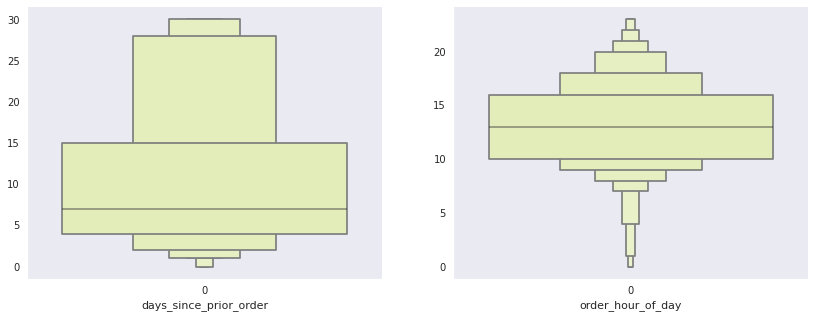

In [ ]:
features = ["days_since_prior_order", "order_hour_of_day"]
fig, axs = plt.subplots(ncols=len(features), figsize=(7*len(features), 5))
for i in range(len(features)):
  sns.boxenplot(data=orders[features[i]],
                showfliers=True,
                ax=axs[i],
                ).set(xlabel=features[i])
  sns.despine()

The data seems to be clear of outliers. Overall, the data is clean and doesn't require preprocessing.

# 4. Feature Engineering


##4.1. Orders Features

In [ ]:
orders= orders.fillna(-1)
orders.head()

order_id  user_id eval_set  order_number  order_dow  order_hour_of_day  \
0   2539329        1    prior             1          2                  8   
1   2398795        1    prior             2          3                  7   
2    473747        1    prior             3          3                 12   
3   2254736        1    prior             4          4                  7   
4    431534        1    prior             5          4                 15   

   days_since_prior_order  
0                    -1.0  
1                    15.0  
2                    21.0  
3                    29.0  
4                    28.0

In [ ]:
orders_prod = orders.set_index('order_id').join(ordProdPrior.set_index('order_id')).reset_index().dropna()
orders_prod['department'] = products.set_index('product_id').loc[orders_prod['product_id'].astype(int)].department_id.values
orders_prod['department'] = departments.set_index('department_id').loc[orders_prod['department']].values
orders_prod.head()

order_id  user_id eval_set  order_number  order_dow  order_hour_of_day  \
1         2   202279    prior             3          5                  9   
2         2   202279    prior             3          5                  9   
3         2   202279    prior             3          5                  9   
4         2   202279    prior             3          5                  9   
5         2   202279    prior             3          5                  9   

   days_since_prior_order  product_id  add_to_cart_order  reordered  \
1                     8.0     33120.0                1.0        1.0   
2                     8.0     28985.0                2.0        1.0   
3                     8.0      9327.0                3.0        0.0   
4                     8.0     45918.0                4.0        1.0   
5                     8.0     30035.0                5.0        0.0   

   department  
1  dairy eggs  
2     produce  
3      pantry  
4      pantry  
5      pantry

##4.2. User Stats Features

In [ ]:
users_stats = pd.DataFrame()

# Getting total count of orders
users_stats['total_orders'] = orders_prod.groupby('user_id').order_id.nunique()

# Getting total count of orders in each dow
users_dow_count = orders_prod.groupby('user_id').order_dow.value_counts().unstack().fillna(0)
total_products  = orders_prod.groupby('user_id').order_id.count()
for dow in users_dow_count.columns:
    users_stats[f'dow_{dow}']=users_dow_count[dow] / total_products
del users_dow_count
del total_products

# Getting total count of orders in each hour of day
order_hour_of_day_count = orders_prod.groupby('user_id').order_hour_of_day.value_counts().unstack().fillna(0)
total_products  = orders_prod.groupby('user_id').order_id.count()
for order_hour_of_day in order_hour_of_day_count.columns:
    users_stats[f'hod_{order_hour_of_day}']=order_hour_of_day_count[order_hour_of_day] / total_products
del order_hour_of_day_count
del total_products

# Getting count of each department
users_department_count = orders_prod.groupby('user_id').department.value_counts().unstack().fillna(0)
total_products  = orders_prod.groupby('user_id').order_id.count()
for department in users_department_count.columns:
    users_stats[f'department_{department}']=users_department_count[department] / total_products

del users_department_count
del total_products

# Getting ordering rate
users_stats['order_every'] = orders_prod.groupby('user_id').days_since_prior_order.mean()
   
# Getting average basket size for each user
users_stats['basket_size'] = orders_prod.groupby(['user_id','order_id']).product_id.count().reset_index().groupby('user_id').product_id.mean()


users_stats.head()

total_orders     dow_0     dow_1     dow_2     dow_3     dow_4  \
user_id                                                                   
1                  10  0.000000  0.288136  0.152542  0.186441  0.372881   
2                  14  0.000000  0.328205  0.446154  0.148718  0.046154   
3                  12  0.522727  0.181818  0.056818  0.238636  0.000000   
4                   5  0.000000  0.000000  0.000000  0.000000  0.500000   
5                   4  0.243243  0.324324  0.000000  0.432432  0.000000   

            dow_5     dow_6  hod_0  hod_1  ...  department_meat seafood  \
user_id                                    ...                            
1        0.000000  0.000000    0.0    0.0  ...                 0.000000   
2        0.030769  0.000000    0.0    0.0  ...                 0.005128   
3        0.000000  0.000000    0.0    0.0  ...                 0.000000   
4        0.277778  0.222222    0.0    0.0  ...                 0.000000   
5        0.000000  0.000000    0.0    0.0  ...                 0.000000   

         department_missing  department_other  department_pantry  \
user_id                                                            
1                       0.0               0.0           0.016949   
2                       0.0               0.0           0.056410   
3                       0.0               0.0           0.045455   
4                       0.0               0.0           0.000000   
5                       0.0               0.0           0.054054   

         department_personal care  department_pets  department_produce  \
user_id                                                                  
1                        0.000000              0.0            0.084746   
2                        0.005128              0.0            0.184615   
3                        0.000000              0.0            0.431818   
4                        0.000000              0.0            0.111111   
5                        0.000000              0.0            0.513514   

         department_snacks  order_every  basket_size  
user_id                                               
1                 0.372881    18.457627     5.900000  
2                 0.215385    14.835897    13.928571  
3                 0.102273    10.068182     7.333333  
4                 0.055556    11.722222     3.600000  
5                 0.027027     9.891892     9.250000  

[5 rows x 55 columns]

##4.3. Products Features

In [ ]:
# Getting total count of orders in each dow
product_dow_count = orders_prod.groupby('product_id').order_dow.value_counts().unstack().fillna(0)
for dow in product_dow_count.columns:
    products[f'dow_{dow}']=product_dow_count[dow]
del product_dow_count

# Getting total count of orders in each hour of day
product_hod_count = orders_prod.groupby('product_id').order_hour_of_day.value_counts().unstack().fillna(0)
for order_hour_of_day in product_hod_count.columns:
    products[f'hod_{order_hour_of_day}']=product_hod_count[order_hour_of_day]
del product_hod_count

#getting total count of orders including this product
products['orders_count'] = orders_prod.groupby('product_id').order_id.nunique()

#getting the most common add to cart order for every product
products['add_to_cart_order'] = orders_prod.groupby('product_id')['add_to_cart_order'].agg(pd.Series.mode)
#if mode is a list of values, take the minimum
products['add_to_cart_order'] = products['add_to_cart_order'].apply(lambda x: x[0] if isinstance(x,Iterable) else x)

#fill any missing values with 0
products.fillna(0,inplace=True)

products

product_id                                       product_name  \
0               1                         Chocolate Sandwich Cookies   
1               2                                   All-Seasons Salt   
2               3               Robust Golden Unsweetened Oolong Tea   
3               4  Smart Ones Classic Favorites Mini Rigatoni Wit...   
4               5                          Green Chile Anytime Sauce   
...           ...                                                ...   
49683       49684          Vodka, Triple Distilled, Twist of Vanilla   
49684       49685                 En Croute Roast Hazelnut Cranberry   
49685       49686                                   Artisan Baguette   
49686       49687         Smartblend Healthy Metabolism Dry Cat Food   
49687       49688                             Fresh Foaming Cleanser   

       aisle_id  department_id    dow_0    dow_1    dow_2    dow_3    dow_4  \
0            61             19      0.0      0.0      0.0      0.0      0.0   
1           104             13    201.0    400.0    271.0    262.0    295.0   
2            94              7     17.0     13.0      9.0     15.0     10.0   
3            38              1     50.0     61.0     41.0     23.0     19.0   
4             5             13     74.0     54.0     41.0     29.0     43.0   
...         ...            ...      ...      ...      ...      ...      ...   
49683       124              5  22054.0  17435.0  11953.0  10416.0  10165.0   
49684        42              1      1.0      0.0      1.0      0.0      1.0   
49685       112              3      6.0      9.0     10.0      6.0      7.0   
49686        41              8     25.0     20.0     12.0      8.0     15.0   
49687        73             11      2.0      2.0      3.0      2.0      2.0   

         dow_5  ...  hod_16  hod_17  hod_18  hod_19  hod_20  hod_21  hod_22  \
0          0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
1        304.0  ...   141.0   134.0    66.0    52.0    37.0    47.0    32.0   
2          9.0  ...    11.0     6.0     4.0     3.0     1.0     1.0     2.0   
3         28.0  ...    15.0    15.0     8.0     9.0     5.0     8.0     2.0   
4         40.0  ...    34.0    28.0    17.0    11.0    11.0     4.0     5.0   
...        ...  ...     ...     ...     ...     ...     ...     ...     ...   
49683  11220.0  ...  7933.0  6487.0  5067.0  3954.0  3059.0  2491.0  2051.0   
49684      4.0  ...     1.0     0.0     0.0     0.0     0.0     0.0     0.0   
49685      6.0  ...     4.0     2.0     3.0     1.0     3.0     0.0     1.0   
49686     22.0  ...    13.0     8.0     1.0     3.0     2.0     2.0     2.0   
49687      2.0  ...     1.0     0.0     2.0     0.0     0.0     0.0     0.0   

       hod_23  orders_count  add_to_cart_order  
0         0.0           0.0                0.0  
1        38.0        1852.0                1.0  
2         0.0          90.0                1.0  
3         2.0         277.0                1.0  
4        10.0         329.0                7.0  
...       ...           ...                ...  
49683  1228.0       97315.0                2.0  
49684     0.0           9.0                2.0  
49685     1.0          49.0                1.0  
49686     5.0         120.0                3.0  
49687     0.0          13.0                1.0  

[49688 rows x 37 columns]


# 5. General EDA

## 5.1. Customer Level EDA 

In [ ]:
orders_prod.user_id.nunique()

206209

### `Used functions`

In [ ]:
def get_user_percentage_above_n(df,N):  
  print('\n===== Percentage of users above n orders =====')
  for n in N:
    print('\nn= {}'.format(n))
    print('{:.2f}%'.format((len(df[df.total_orders > n]) / len(df)) *100))


### 5.1.1. `Orders statistics`

---


`How many customers order more than n orders ?`
---

---



`Distribution of user orders`
---


In [ ]:
users_stats

total_orders     dow_0     dow_1     dow_2     dow_3     dow_4  \
user_id                                                                   
1                  10  0.000000  0.288136  0.152542  0.186441  0.372881   
2                  14  0.000000  0.328205  0.446154  0.148718  0.046154   
3                  12  0.522727  0.181818  0.056818  0.238636  0.000000   
4                   5  0.000000  0.000000  0.000000  0.000000  0.500000   
5                   4  0.243243  0.324324  0.000000  0.432432  0.000000   
...               ...       ...       ...       ...       ...       ...   
206205              3  0.000000  0.000000  0.250000  0.000000  0.531250   
206206             67  0.238596  0.189474  0.115789  0.157895  0.168421   
206207             16  0.125561  0.192825  0.161435  0.183857  0.026906   
206208             49  0.081241  0.177253  0.258493  0.152142  0.129985   
206209             13  0.015504  0.348837  0.077519  0.263566  0.108527   

            dow_5     dow_6  hod_0  hod_1  ...  department_meat seafood  \
user_id                                    ...                            
1        0.000000  0.000000    0.0    0.0  ...                 0.000000   
2        0.030769  0.000000    0.0    0.0  ...                 0.005128   
3        0.000000  0.000000    0.0    0.0  ...                 0.000000   
4        0.277778  0.222222    0.0    0.0  ...                 0.000000   
5        0.000000  0.000000    0.0    0.0  ...                 0.000000   
...           ...       ...    ...    ...  ...                      ...   
206205   0.218750  0.000000    0.0    0.0  ...                 0.031250   
206206   0.035088  0.094737    0.0    0.0  ...                 0.007018   
206207   0.134529  0.174888    0.0    0.0  ...                 0.026906   
206208   0.115214  0.085672    0.0    0.0  ...                 0.032496   
206209   0.186047  0.000000    0.0    0.0  ...                 0.015504   

         department_missing  department_other  department_pantry  \
user_id                                                            
1                  0.000000          0.000000           0.016949   
2                  0.000000          0.000000           0.056410   
3                  0.000000          0.000000           0.045455   
4                  0.000000          0.000000           0.000000   
5                  0.000000          0.000000           0.054054   
...                     ...               ...                ...   
206205             0.031250          0.000000           0.000000   
206206             0.000000          0.003509           0.049123   
206207             0.000000          0.000000           0.067265   
206208             0.002954          0.000000           0.056130   
206209             0.000000          0.000000           0.062016   

         department_personal care  department_pets  department_produce  \
user_id                                                                  
1                        0.000000              0.0            0.084746   
2                        0.005128              0.0            0.184615   
3                        0.000000              0.0            0.431818   
4                        0.000000              0.0            0.111111   
5                        0.000000              0.0            0.513514   
...                           ...              ...                 ...   
206205                   0.000000              0.0            0.218750   
206206                   0.035088              0.0            0.119298   
206207                   0.000000              0.0            0.224215   
206208                   0.007386              0.0            0.290990   
206209                   0.000000              0.0            0.147287   

         department_snacks  order_every  basket_size  
user_id                                               
1                 0.372881    18.457627     5.900000  
2                 0.215385    14.835897    1

In [ ]:
print('===== USERS COUNT =====')
print('Number of users: {}'.format(len(users_stats)))

===== USERS COUNT =====
Number of users: 206209


In [ ]:
get_user_percentage_above_n(users_stats,np.arange(0,55,5))


===== Percentage of users above n orders =====

n= 0
100.00%

n= 5
71.03%

n= 10
45.53%

n= 15
31.66%

n= 20
23.19%

n= 25
17.44%

n= 30
13.44%

n= 35
10.52%

n= 40
8.25%

n= 45
6.48%

n= 50
5.01%


Text(0.5, 1.0, 'Total orders distribution')

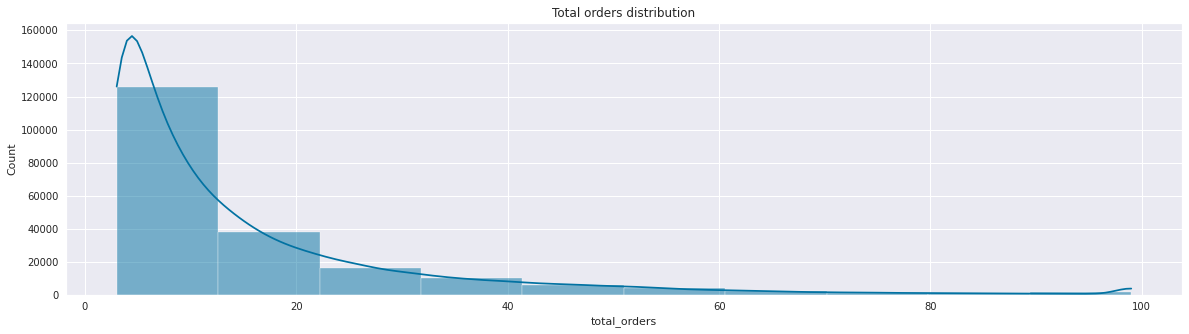

In [ ]:
plt.figure(figsize=(20,5))
sns.histplot(data=users_stats, x="total_orders",bins=10, kde=True)
plt.title('Total orders distribution')

### 5.1.2. `User Retention`

---
`How many customers are loyal ?`
---
---
`What is the behaviour of loyal customers vs Normal customers?`
---
---

In [ ]:
users_order_number = orders_prod[['user_id','order_number']]
users_order_number = users_order_number.drop_duplicates()

new_users = users_order_number[users_order_number['order_number'] == i].user_id.unique()
new_users_number = len(users_order_number[users_order_number['order_number'] == i].user_id.unique())
new_users_orders_prod = users_order_number[users_order_number['user_id'].isin(new_users)]

retention_precentages = []
retention_n = []

for i in range(5,105,5):
  retention_n.append(i)
  new_users = new_users_orders_prod[new_users_orders_prod['order_number'] == i].user_id.unique()
  new_users_orders_prod = new_users_orders_prod[new_users_orders_prod['user_id'].isin(new_users)]
  
  retention_precentages.append(len(new_users)/new_users_number*100)


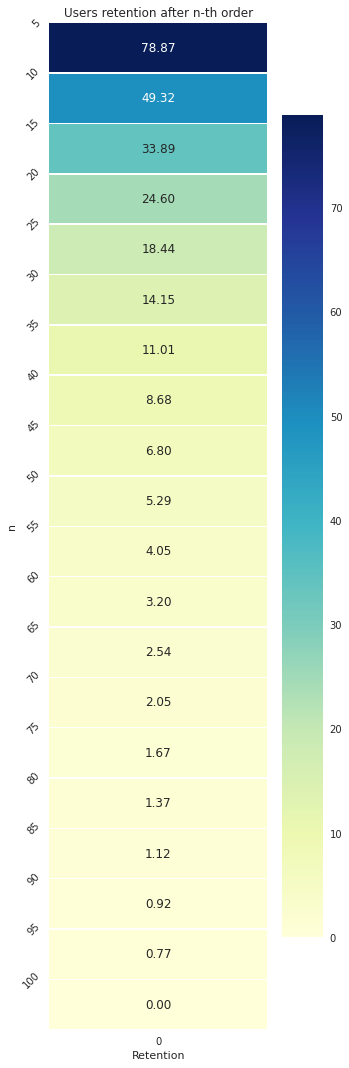

In [ ]:
plt.figure(figsize=(5,15))
fig = sns.heatmap(np.array(retention_precentages).reshape(-1,1),fmt='.2f', linewidths=.5,annot=True,cmap="YlGnBu")
plt.title('Users retention after n-th order')
plt.ylabel('n')
plt.xlabel('Retention')
_=plt.yticks(np.arange(0,len(retention_n)),retention_n)
_= plt.xticks()
_=plt.margins(y=1)
plt.setp( fig.yaxis.get_majorticklabels(), rotation=45 ) 
plt.tight_layout()


We can conclude that only **18%** of new customers are still ordering more.

Customers that order more thatn **30** order are considered **loyal**

In [ ]:
loyal_new_customers= orders_prod.drop(['product_id','add_to_cart_order','reordered','department','eval_set'],axis=1).drop_duplicates()
loyal_new_customers['segment'] = loyal_new_customers['order_number'] >=30
loyal_new_customers['segment'] = loyal_new_customers['segment'].apply(lambda x: 'loyal' if x else 'normal')
loyal_customers_id = loyal_new_customers[loyal_new_customers['segment']=='loyal'].user_id.unique()
loyal_new_customers.head()

order_id  user_id  order_number  order_dow  order_hour_of_day  \
1          2   202279             3          5                  9   
10         3   205970            16          5                 17   
18         4   178520            36          1                  9   
31         5   156122            42          6                 16   
57         6    22352             4          1                 12   

    days_since_prior_order segment  
1                      8.0  normal  
10                    12.0  normal  
18                     7.0   loyal  
31                     9.0   loyal  
57                    30.0  normal

In [ ]:
print('===== LOYAL CUSTOMERS =====')
print(f'Number of loyal customers {len(loyal_customers_id)}')
print(f'Percentage of loyal customers {len(loyal_customers_id)/len(users_stats)*100} %')

===== LOYAL CUSTOMERS =====
Number of loyal customers 29183
Percentage of loyal customers 14.15214660853794 %


Text(0.5, 1.0, 'How many loyal and normal customers order every n days')

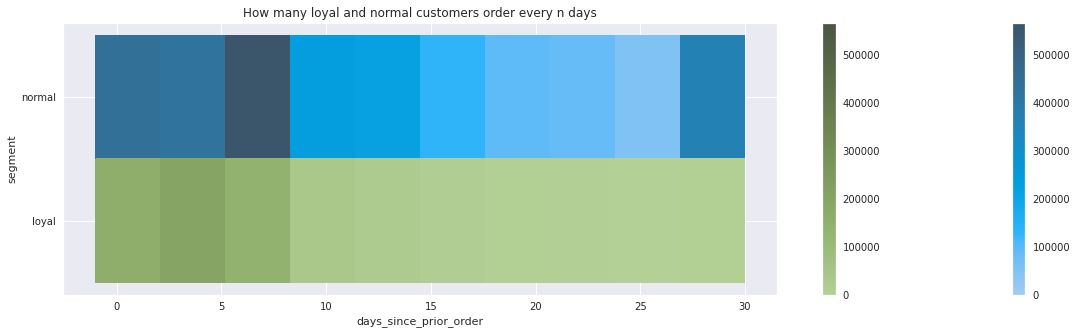

In [ ]:
plt.figure(figsize=(20,5))
sns.histplot(
    loyal_new_customers, x="days_since_prior_order", y="segment", hue="segment",bins=10, legend=False, cbar=True
)
plt.title('How many loyal and normal customers order every n days')

Text(0.5, 1.0, 'Customers behaviour every day of week')

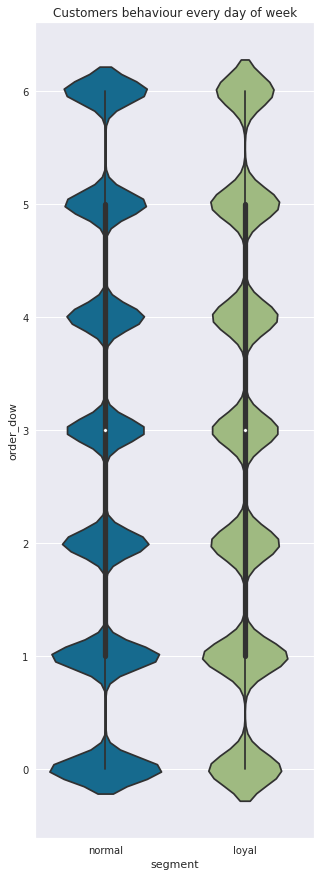

In [ ]:
plt.figure(figsize=(5,15))
ax = sns.violinplot(x="segment", y="order_dow", data=loyal_new_customers)
plt.title('Customers behaviour every day of week')

Text(0.5, 1.0, 'Customers behaviour every hour of day')

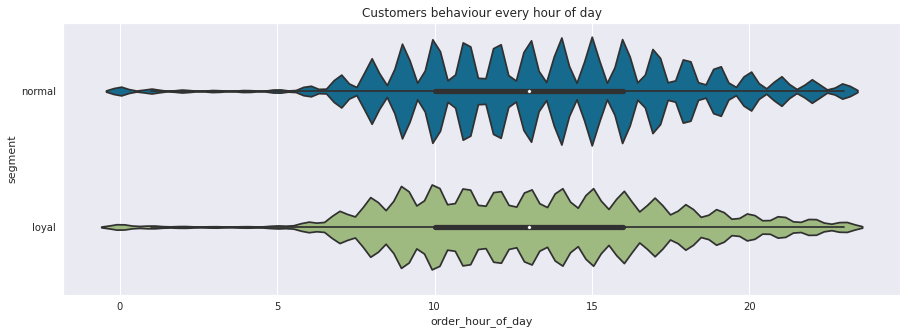

In [ ]:
plt.figure(figsize=(15,5))
ax = sns.violinplot(x="order_hour_of_day", y="segment", data=loyal_new_customers)
plt.title('Customers behaviour every hour of day')

We can see that the period from **0 to 4** has a constant low pattern, **5 to 9** has an increasing pattern, **10 to 14** has a constant high pattern, **15 to 19** has a deacreasing pattern, and **20 to 24** has constant mid pattern   

In [ ]:
del loyal_new_customers

## 5.2. Product related levels EDA

### 5.2.1. `Order time statistics`

---
`What are the most popular products in each hour of day?`
---
---
`What are the most popular departments each day of week?`
---
---

In [ ]:
hod_intervals = [[0,4],[5,9],[10,14],[15,19],[20,24]]

In [ ]:
hod_intervals = np.array(hod_intervals)
hod_intervals

array([[ 0,  4],
       [ 5,  9],
       [10, 14],
       [15, 19],
       [20, 24]])

In [ ]:
hod_intervals_label = pd.Series(dtype=str)
hod_intervals_label_list = ['0-4','5-9','10-14','15-19','20-24']
for i,interval in enumerate(hod_intervals):
  for t in range(interval[0],interval[1]+1):
    hod_intervals_label.loc[t] = hod_intervals_label_list[i]

hod_intervals_label

0       0-4
1       0-4
2       0-4
3       0-4
4       0-4
5       5-9
6       5-9
7       5-9
8       5-9
9       5-9
10    10-14
11    10-14
12    10-14
13    10-14
14    10-14
15    15-19
16    15-19
17    15-19
18    15-19
19    15-19
20    20-24
21    20-24
22    20-24
23    20-24
24    20-24
dtype: object

In [ ]:
products=products.set_index('product_id')
products.head()

product_name  aisle_id  \
product_id                                                                
1                                  Chocolate Sandwich Cookies        61   
2                                            All-Seasons Salt       104   
3                        Robust Golden Unsweetened Oolong Tea        94   
4           Smart Ones Classic Favorites Mini Rigatoni Wit...        38   
5                                   Green Chile Anytime Sauce         5   

            department_id  
product_id                 
1                      19  
2                      13  
3                       7  
4                       1  
5                      13

In [ ]:
reduced_orders_prod = orders_prod.drop(['order_id','user_id','order_number','add_to_cart_order','eval_set'],axis=1)
#reduced_orders_prod['product_id'] = products.product_name.loc[reduced_orders_prod['product_id'].values]
reduced_orders_prod.rename(columns={'product_id':'product'},inplace=True)
reduced_orders_prod.head()

order_dow  order_hour_of_day  days_since_prior_order  product  reordered  \
1          5                  9                     8.0  33120.0        1.0   
2          5                  9                     8.0  28985.0        1.0   
3          5                  9                     8.0   9327.0        0.0   
4          5                  9                     8.0  45918.0        1.0   
5          5                  9                     8.0  30035.0        0.0   

   department  
1  dairy eggs  
2     produce  
3      pantry  
4      pantry  
5      pantry

In [ ]:
hod_products_count  = reduced_orders_prod.groupby('order_hour_of_day').product.value_counts()
hod_products_count  = pd.DataFrame(hod_products_count).rename(columns={'product':'counts'}).reset_index()

In [ ]:
interval_counts = []
hod_products_count['order_hour_of_day_interval'] = hod_intervals_label.loc[hod_products_count['order_hour_of_day']].values
hog_products_largest = hod_products_count.groupby(['order_hour_of_day_interval','product']).counts.sum()
hog_products_largest
#interval_counts.append[(hod_products_count['order_hour_of_day'] >= 0) & (hod_products_count['order_hour_of_day'] < 5).sum()]

order_hour_of_day_interval  product
0-4                         1.0        41
                            2.0         2
                            3.0        14
                            4.0         6
                            5.0         1
                                       ..
5-9                         49684.0     2
                            49685.0     7
                            49686.0    18
                            49687.0     2
                            49688.0    17
Name: counts, Length: 215357, dtype: int64

In [ ]:
products

product_name  aisle_id  \
product_id                                                                
1                                  Chocolate Sandwich Cookies        61   
2                                            All-Seasons Salt       104   
3                        Robust Golden Unsweetened Oolong Tea        94   
4           Smart Ones Classic Favorites Mini Rigatoni Wit...        38   
5                                   Green Chile Anytime Sauce         5   
...                                                       ...       ...   
49684               Vodka, Triple Distilled, Twist of Vanilla       124   
49685                      En Croute Roast Hazelnut Cranberry        42   
49686                                        Artisan Baguette       112   
49687              Smartblend Healthy Metabolism Dry Cat Food        41   
49688                                  Fresh Foaming Cleanser        73   

            department_id  
product_id                 
1                      19  
2                      13  
3                       7  
4                       1  
5                      13  
...                   ...  
49684                   5  
49685                   1  
49686                   3  
49687                   8  
49688                  11  

[49688 rows x 3 columns]

In [ ]:
cloud_texts = ['','','','','']
for i,interval in enumerate(hod_intervals_label_list):
  top_product_interval_frequency = np.round((hog_products_largest.loc[interval].nlargest(50) / hog_products_largest.loc[interval].sum()) *100000).astype(int)
  top_products_names = products['product_name'].loc[top_product_interval_frequency.index]
  top_products_frequnecies = top_product_interval_frequency.values
  for j,name in enumerate(top_products_names):
    cloud_texts[i] += (name+' ') * top_products_frequnecies[j]
  

In [ ]:
first_mask = np.array(Image.open("/content/imgs/12_4.png"))
second_mask = np.array(Image.open("/content/imgs/2_9.png"))
third_mask = np.array(Image.open("/content/imgs/10_2.png"))
forth_mask = np.array(Image.open("/content/imgs/3_7.png"))
fifth_mask = np.array(Image.open("/content/imgs/8_12.png"))

first_mask[first_mask==0] = 255
second_mask[second_mask==0] = 255
third_mask[third_mask==0] = 255
forth_mask[forth_mask==0] = 255
fifth_mask[fifth_mask==0] = 255

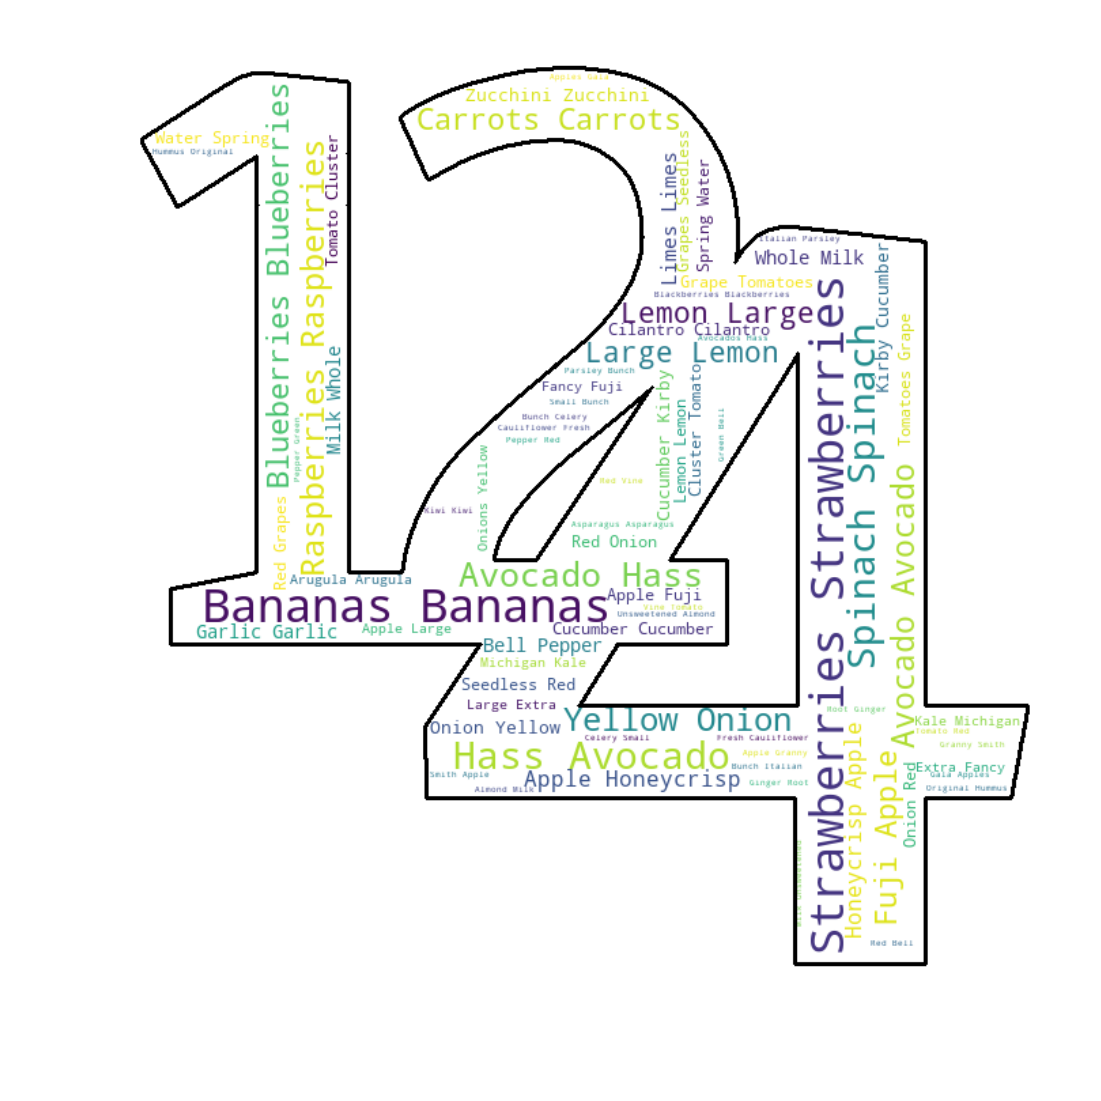

In [ ]:
# Create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(["Bag", "of", "Organic", "Baby", "Banana"])

plt.figure(figsize=(20,20))
# Create and generate a word cloud image:
wordcloud = WordCloud(width=800, height=800, mask=first_mask,background_color="white",
               stopwords=stopwords, contour_width=3, contour_color='black').generate(cloud_texts[0])

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
_= plt.axis("off")

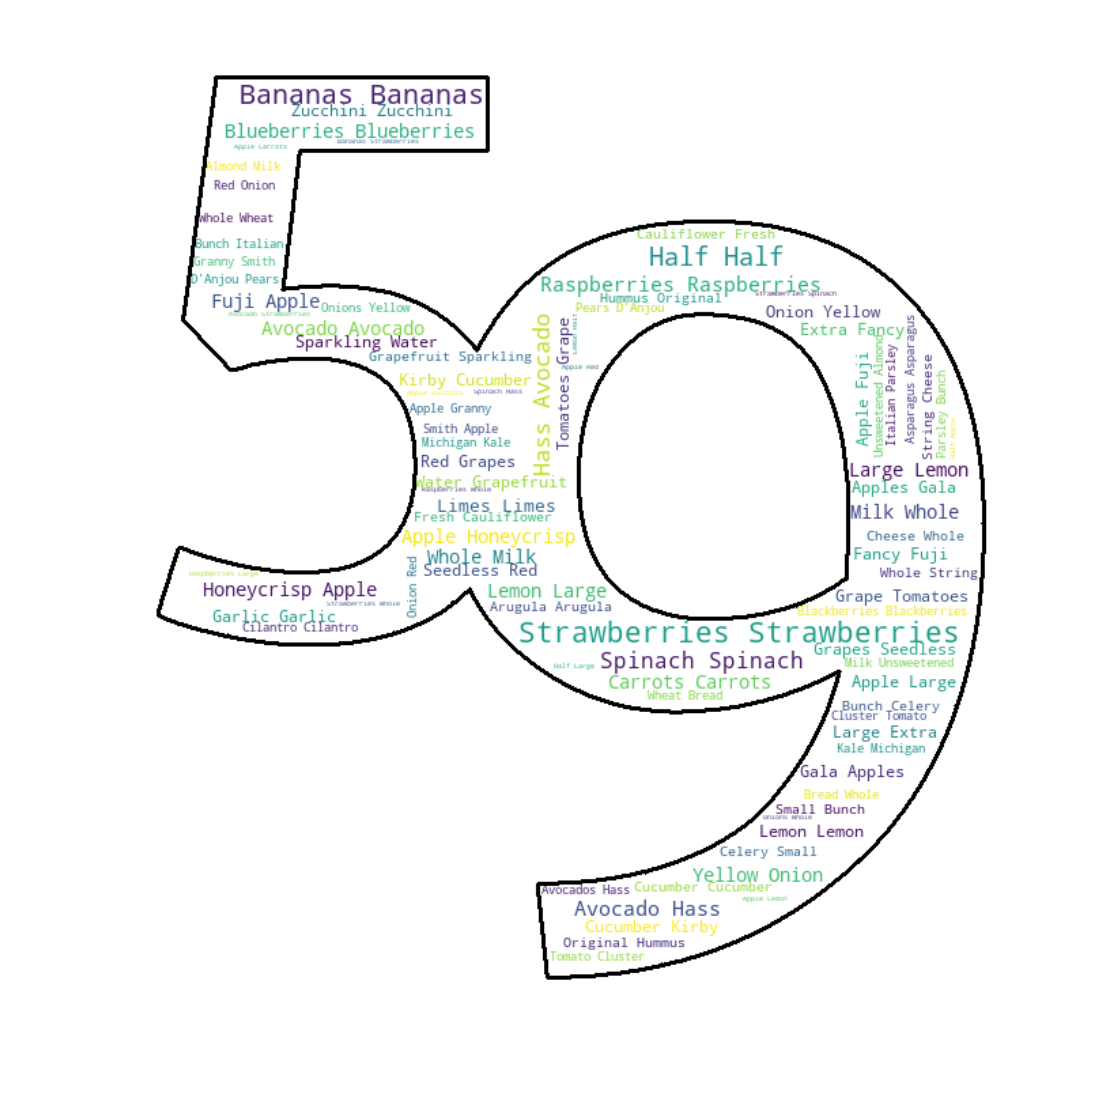

In [ ]:
# Create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(["Bag", "of", "Organic", "Baby", "Banana"])

plt.figure(figsize=(20,20))
# Create and generate a word cloud image:
wordcloud = WordCloud(width=800, height=800, mask=second_mask,background_color="white",
               stopwords=stopwords, contour_width=3, contour_color='black').generate(cloud_texts[1])

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
_= plt.axis("off")

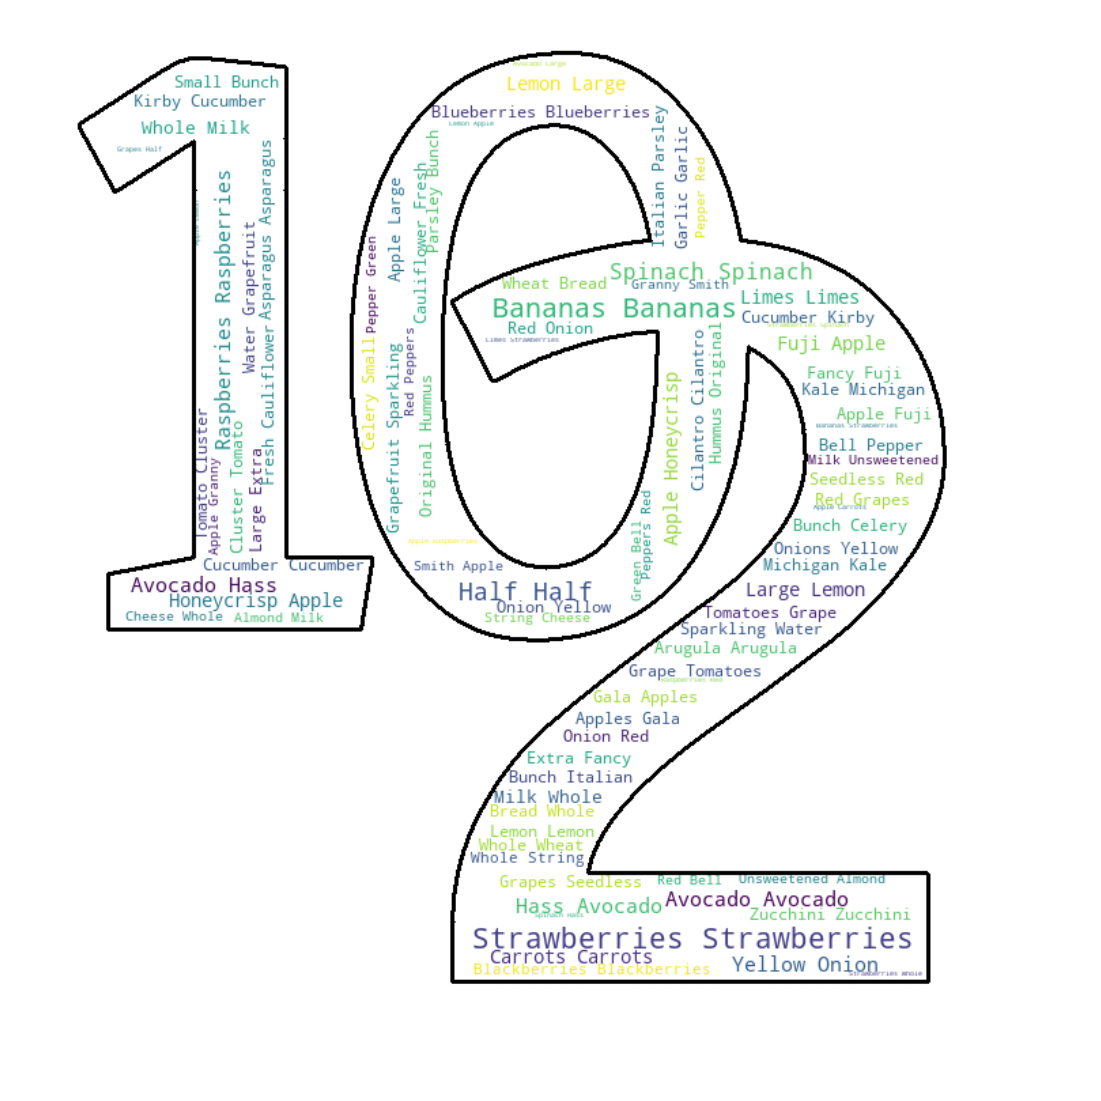

In [ ]:
# Create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(["Bag", "of", "Organic", "Baby", "Banana"])

plt.figure(figsize=(20,20))
# Create and generate a word cloud image:
wordcloud = WordCloud(width=800, height=800, mask=third_mask,background_color="white",
               stopwords=stopwords, contour_width=3, contour_color='black').generate(cloud_texts[2])

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
_= plt.axis("off")

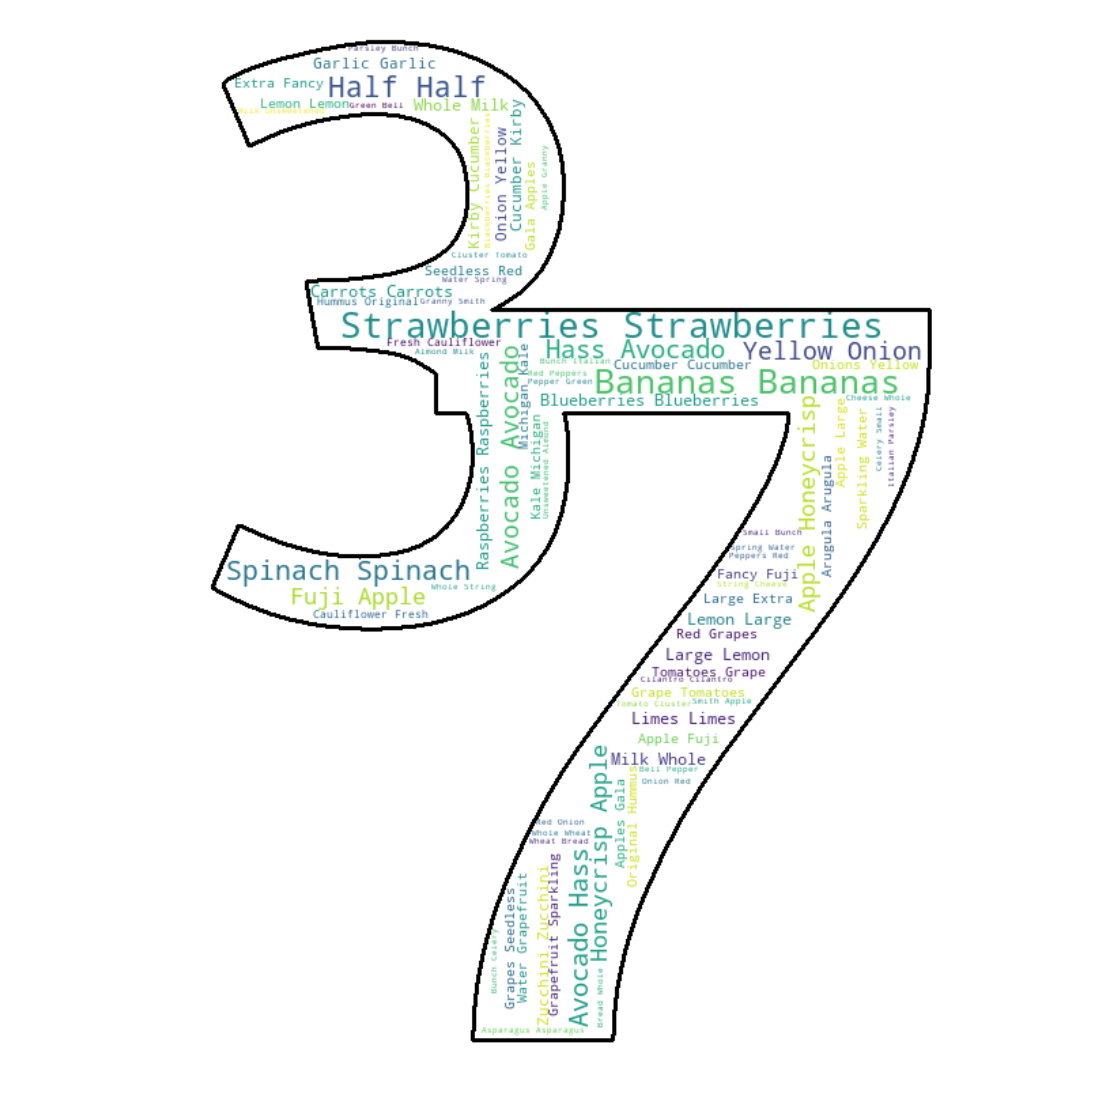

In [ ]:
# Create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(["Bag", "of", "Organic", "Baby", "Banana"])

plt.figure(figsize=(20,20))
# Create and generate a word cloud image:
wordcloud = WordCloud(width=800, height=800, mask=forth_mask,background_color="white",
               stopwords=stopwords, contour_width=3, contour_color='black').generate(cloud_texts[3])

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
_= plt.axis("off")

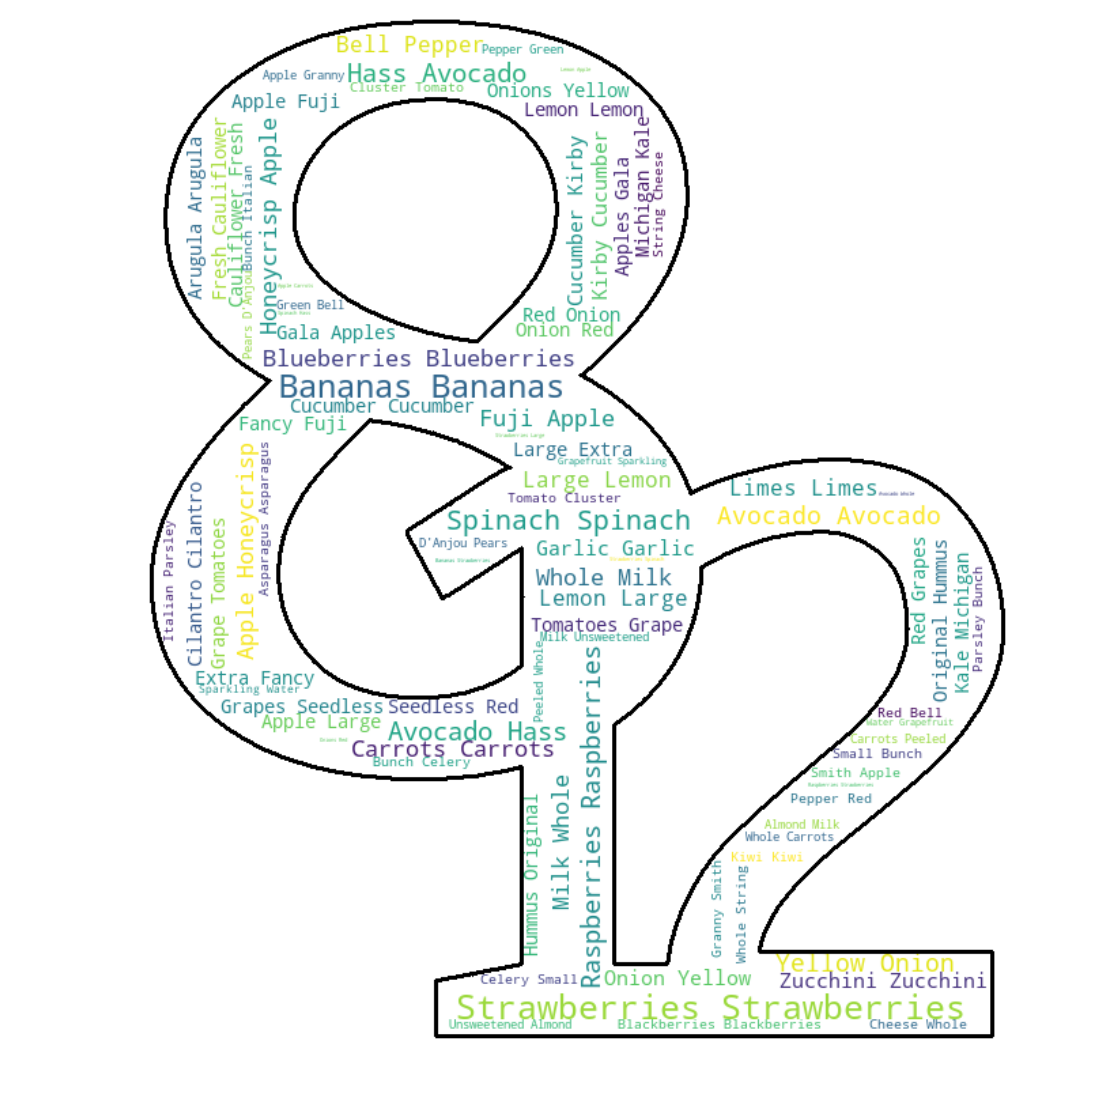

In [ ]:
# Create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(["Bag", "of", "Organic", "Baby", "Banana"])

plt.figure(figsize=(20,20))
# Create and generate a word cloud image:
wordcloud = WordCloud(width=800, height=800, mask=fifth_mask,background_color="white",
               stopwords=stopwords, contour_width=3, contour_color='black').generate(cloud_texts[4])

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
_= plt.axis("off")

In [ ]:
department_dow_count = reduced_orders_prod.groupby('order_dow').department.value_counts()
department_dow_count = department_dow_count.unstack()
department_dow_count

department  alcohol  babies  bakery  beverages  breakfast  bulk  canned goods  \
order_dow                                                                       
0             17437   81622  225382     433110     127162  6137        228161   
1             20600   73057  204386     482695     129413  6339        179995   
2             20325   56698  152710     371531      95858  4559        132596   
3             22459   52455  139410     344815      87143  4246        119361   
4             26142   51568  137722     340146      85445  3989        115153   
5             27429   51573  153850     376179      94329  4580        129185   
6             19304   56829  163327     341653      90219  4723        163607   

department  dairy eggs    deli  dry goods pasta  ...  household  \
order_dow                                        ...              
0              1020167  209526           182149  ...     126237   
1               957422  184736           147855  ...     121267   
2               708983  135582           111066  ...     100229   
3               641481  122133            98761  ...      95575   
4               635983  119669            95849  ...      93391   
5               712251  134434           103684  ...      99366   
6               737729  145169           127263  ...     102601   

department  international  meat seafood  missing  other  pantry  \
order_dow                                                         
0                   55728        151417    13220   6086  351950   
1                   46394        119042    11378   5978  305068   
2                   34429         86830     8574   4969  240848   
3                   31540         77950     8312   4602  227591   
4                   29598         76907     8174   4563  225128   
5                   32836         87963     9415   5053  248719   
6                   38728        108822    10072   5040  276273   

department  personal care   pets  produce  snacks  
order_dow                                          
0                   80387  17151  1953784  483709  
1                   72223  14526  1685056  537636  
2                   59931  11924  1198541  399307  
3                   57299  12589  1069260  360898  
4                   55144  12417  1052458  357680  
5                   57888  13704  1181596  394519  
6                   64251  15413  1338596  353801  

[7 rows x 21 columns]

Text(0.5, 1.0, 'Day of week effect on each departments')

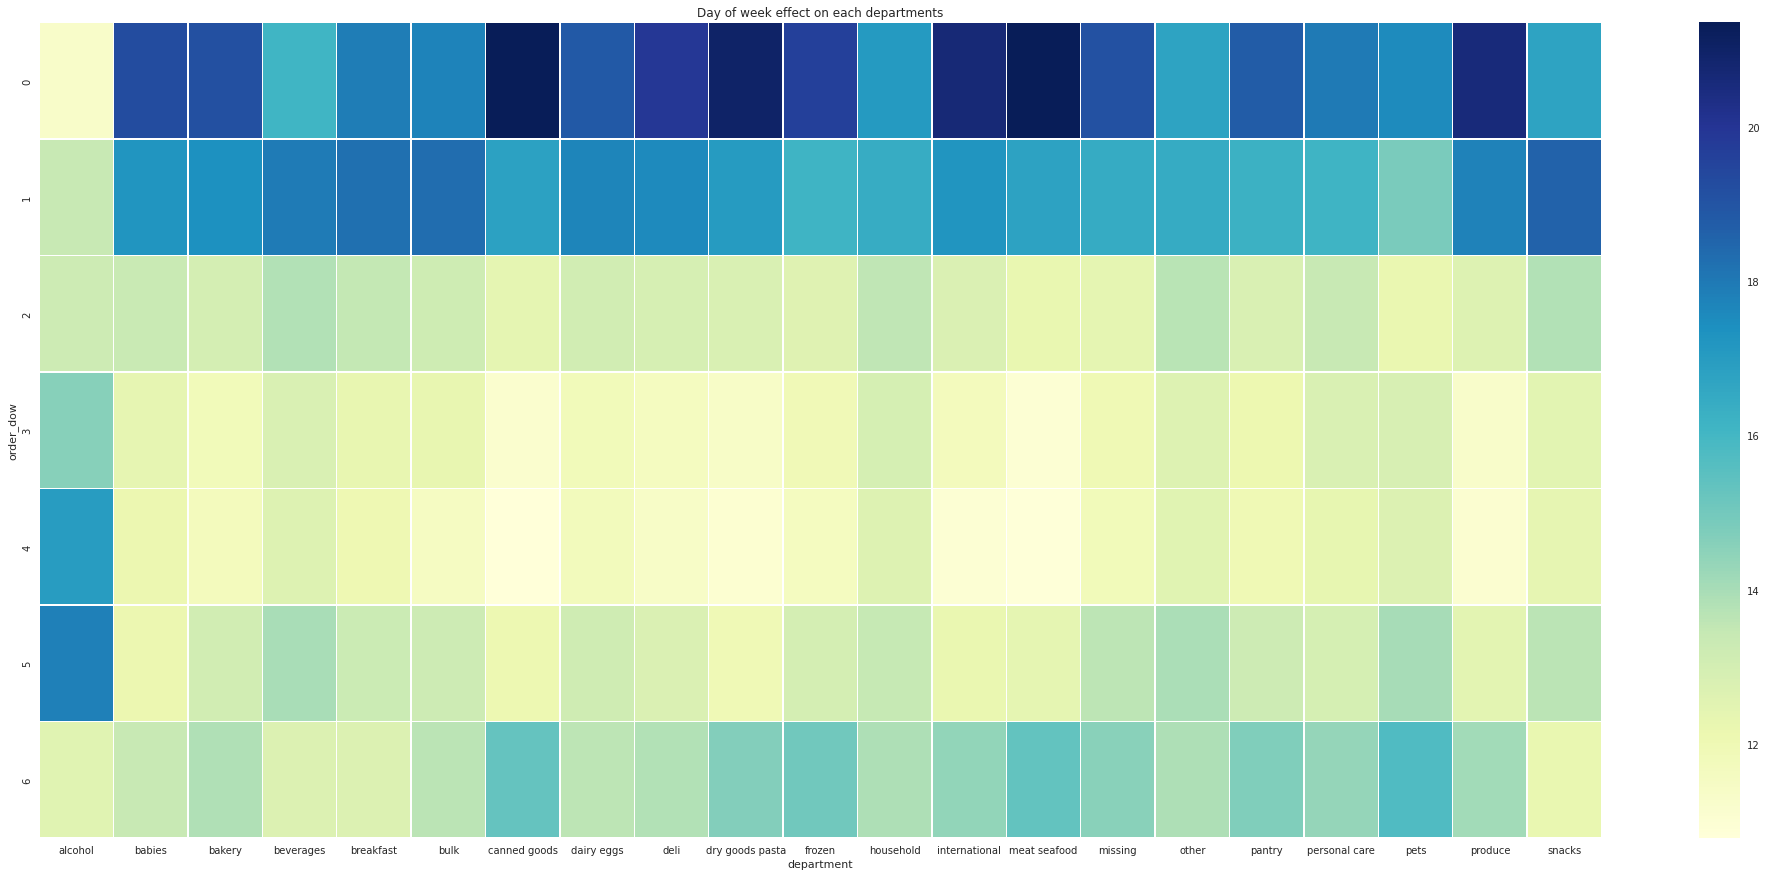

In [ ]:
plt.figure(figsize=(35,15))
sns.heatmap(department_dow_count / department_dow_count.sum(axis=0) * 100,cbar=True, linewidths=.5, cmap="YlGnBu")
plt.title('Day of week effect on each departments')

Text(0.5, 1.0, 'Departments  effect on each Day of week')

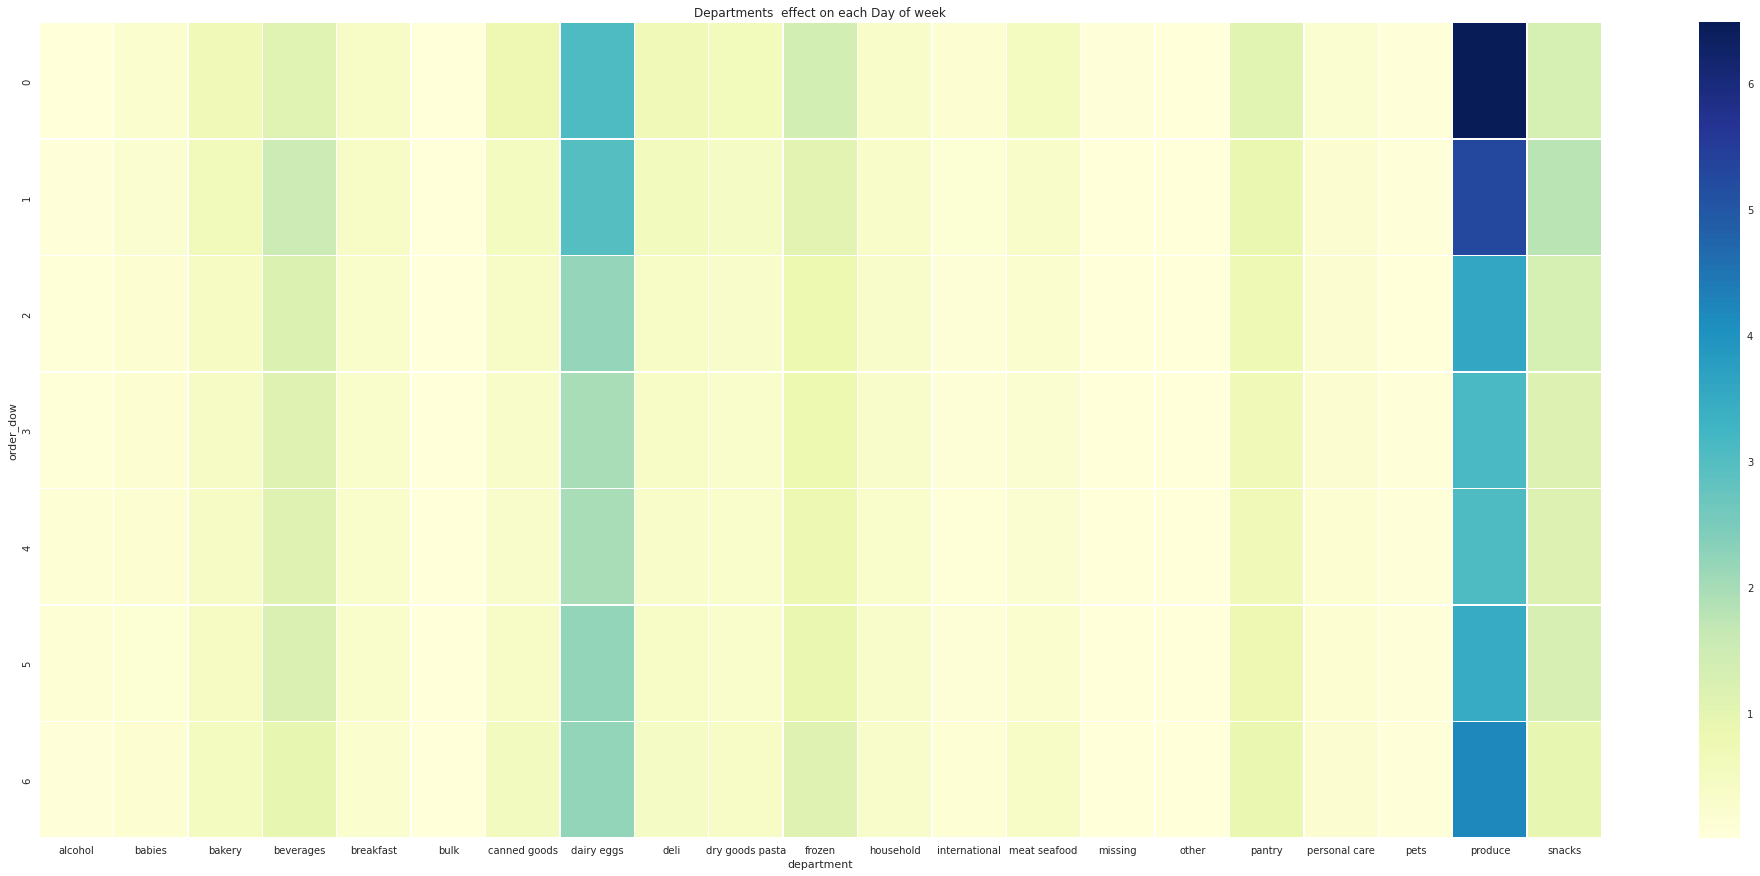

In [ ]:
plt.figure(figsize=(35,15))
sns.heatmap((department_dow_count / department_dow_count.sum(axis=0)) * (department_dow_count.T / department_dow_count.sum(axis=1)).T * 100,cbar=True, linewidths=.5, cmap="YlGnBu")
plt.title('Departments  effect on each Day of week')

### 5.2.1. `Loyality`

---
`What is the beaviour of loyal vs normal customers in terms of products ?`
---
---
`What is the beaviour of loyal vs normal customers in terms of departments ?`
---
---

In [ ]:
loyal_new_customers= orders_prod.drop(['product_id','add_to_cart_order','reordered','department','eval_set','order_dow','order_dow','days_since_prior_order'],axis=1).drop_duplicates()
loyal_new_customers['segment'] = loyal_new_customers['order_number'] >=30
loyal_new_customers['segment'] = loyal_new_customers['segment'].apply(lambda x: 'loyal' if x else 'normal')
loyal_customers_id = loyal_new_customers[loyal_new_customers['segment']=='loyal'].user_id.unique()
loyal_customers_id

array([178520, 156122,  18194, ...,   3544, 163044, 103510])

In [ ]:
del loyal_new_customers

In [ ]:
reduced_orders_prod = orders_prod.drop(['order_number','add_to_cart_order','eval_set'],axis=1)
reduced_orders_prod['loyality'] = 'normal'
reduced_orders_prod.loc[reduced_orders_prod['user_id'].isin(loyal_customers_id),'loyality'] = 'loyal'
reduced_orders_prod.head()

order_id  user_id  order_dow  order_hour_of_day  days_since_prior_order  \
1         2   202279          5                  9                     8.0   
2         2   202279          5                  9                     8.0   
3         2   202279          5                  9                     8.0   
4         2   202279          5                  9                     8.0   
5         2   202279          5                  9                     8.0   

   product_id  reordered  department loyality  
1     33120.0        1.0  dairy eggs   normal  
2     28985.0        1.0     produce   normal  
3      9327.0        0.0      pantry   normal  
4     45918.0        1.0      pantry   normal  
5     30035.0        0.0      pantry   normal

In [ ]:
reduced_orders_prod['loyality'].unique()

array(['normal', 'loyal'], dtype=object)

In [ ]:
reduced_orders_prod.shape

(32434489, 9)

In [ ]:
deparment_dow_loyality_counts  = reduced_orders_prod.groupby(['department','order_dow']).loyality.value_counts()
deparment_dow_loyality_counts

department  order_dow  loyality
alcohol     0          normal       11506
                       loyal         5931
            1          normal       12784
                       loyal         7816
            2          normal       12439
                                    ...  
snacks      4          loyal       171325
            5          normal      197416
                       loyal       197103
            6          normal      201728
                       loyal       152073
Name: loyality, Length: 294, dtype: int64

In [ ]:
deparment_dow_loyality_counts = pd.DataFrame(deparment_dow_loyality_counts).rename(columns={'loyality':'count'}).reset_index()
deparment_dow_loyality_counts

department  order_dow loyality   count
0      alcohol          0   normal   11506
1      alcohol          0    loyal    5931
2      alcohol          1   normal   12784
3      alcohol          1    loyal    7816
4      alcohol          2   normal   12439
..         ...        ...      ...     ...
289     snacks          4    loyal  171325
290     snacks          5   normal  197416
291     snacks          5    loyal  197103
292     snacks          6   normal  201728
293     snacks          6    loyal  152073

[294 rows x 4 columns]

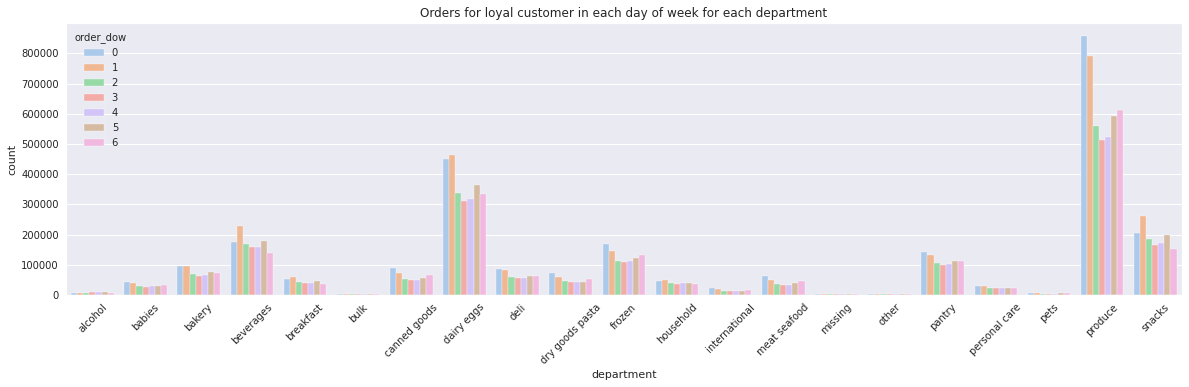

In [ ]:
plt.figure(figsize=(20,5))
ax = sns.barplot(x="department", y="count", hue="order_dow",
                   data=deparment_dow_loyality_counts[deparment_dow_loyality_counts['loyality']=='loyal'],palette= sns.color_palette("pastel"))
#sns.histplot(, x="department", y="count", hue="order_dow")
plt.xticks(rotation = 45) # Rotates X-Axis Ticks by 45-degrees
_= plt.title('Orders for loyal customer in each day of week for each department')


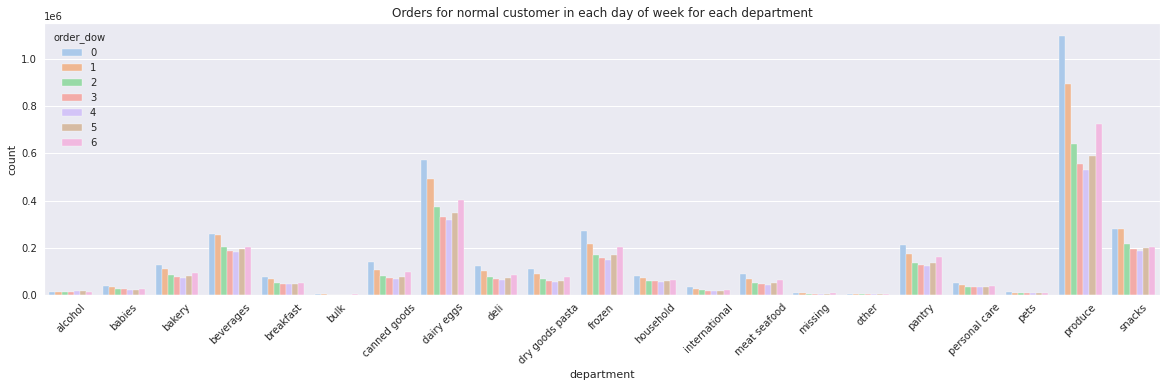

In [ ]:
plt.figure(figsize=(20,5))
ax = sns.barplot(x="department", y="count", hue="order_dow",
                   data=deparment_dow_loyality_counts[deparment_dow_loyality_counts['loyality']=='normal'],palette= sns.color_palette("pastel"))
#sns.histplot(, x="department", y="count", hue="order_dow")
plt.xticks(rotation = 45) # Rotates X-Axis Ticks by 45-degrees
_= plt.title('Orders for normal customer in each day of week for each department')


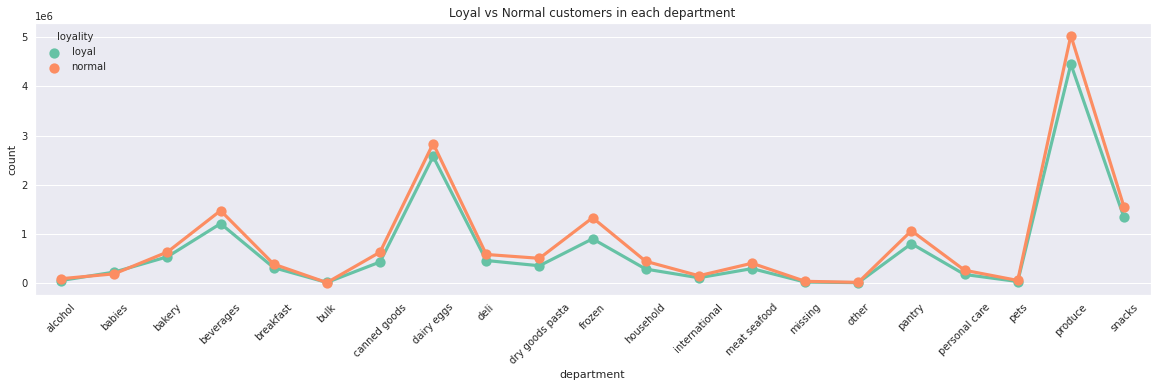

In [ ]:
plt.figure(figsize=(20,5))
ax = sns.pointplot(x="department", y="count", hue="loyality",
                   data=pd.DataFrame(deparment_dow_loyality_counts.groupby(['department','loyality'])['count'].sum()).reset_index(),
                   palette="Set2")
#sns.histplot(, x="department", y="count", hue="order_dow")
plt.xticks(rotation = 45) # Rotates X-Axis Ticks by 45-degrees
_= plt.title('Loyal vs Normal customers in each department')


In [ ]:
loyal_product_count = reduced_orders_prod.groupby(['loyality','product_id']).user_id.count()


In [ ]:
products=products.set_index('product_id')
products.head()

product_name  aisle_id  \
product_id                                                                
1                                  Chocolate Sandwich Cookies        61   
2                                            All-Seasons Salt       104   
3                        Robust Golden Unsweetened Oolong Tea        94   
4           Smart Ones Classic Favorites Mini Rigatoni Wit...        38   
5                                   Green Chile Anytime Sauce         5   

            department_id  
product_id                 
1                      19  
2                      13  
3                       7  
4                       1  
5                      13

In [ ]:
cloud_text = ['','']
for i,l in enumerate(reduced_orders_prod['loyality'].unique()):
  top_100_products  = loyal_product_count.loc[l].nlargest(100)
  top_100_products_name = products['product_name'].loc[top_100_products.index].values
  for j,name in enumerate(top_100_products_name):
    cloud_text[i] += (top_100_products_name[j] + ' ') * top_100_products.iloc[j]


In [ ]:
reduced_orders_prod['loyality'].unique()

array(['normal', 'loyal'], dtype=object)

In [ ]:
first_mask = np.array(Image.open("/content/imgs/LOYAL.png"))
second_mask = np.array(Image.open("/content/imgs/NORMAL.png"))


first_mask[first_mask==0] = 255
second_mask[second_mask==0] = 255


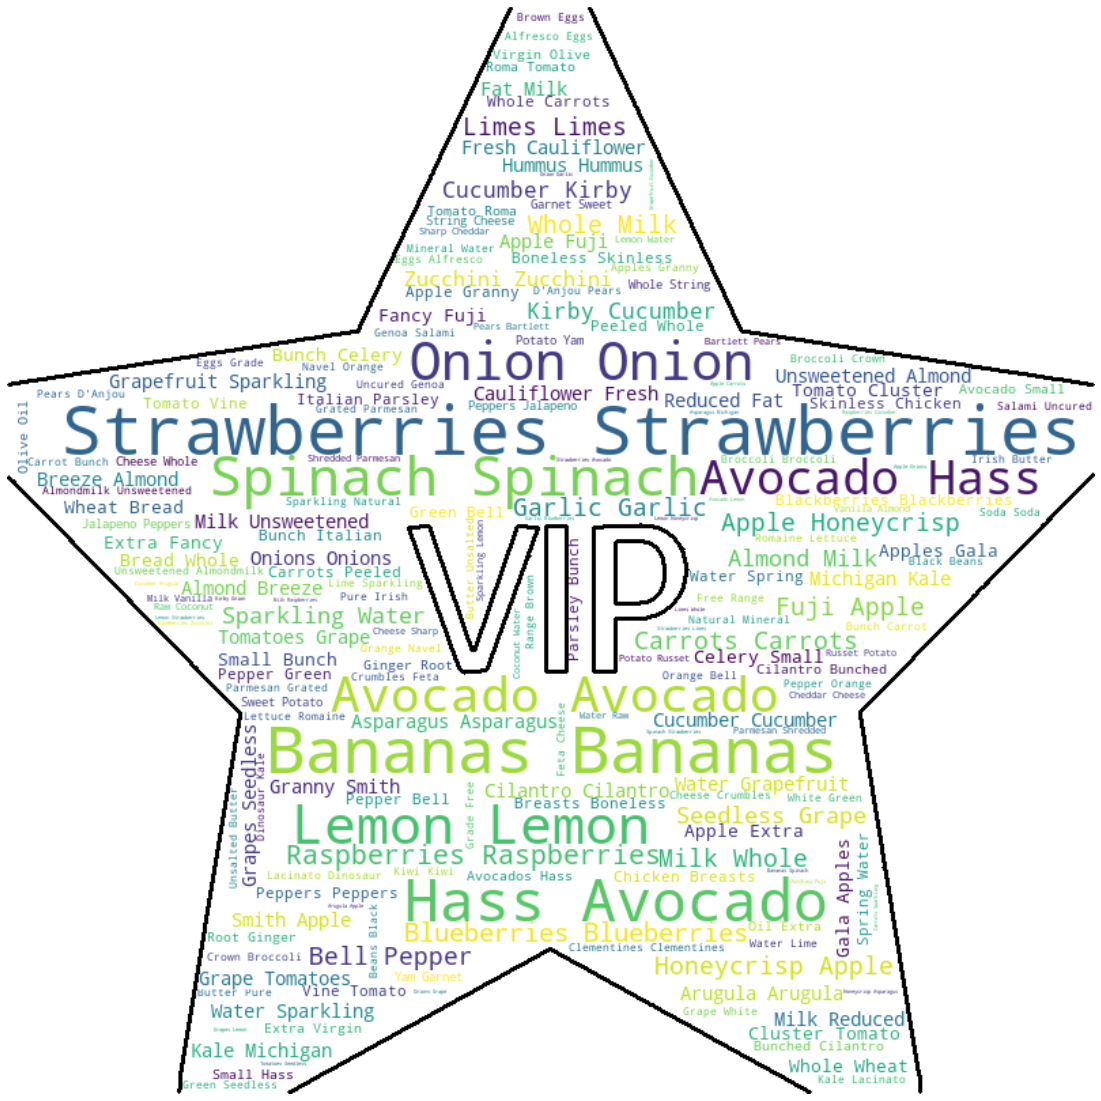

In [ ]:
# Create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(["Bag", "of", "Organic", "Baby", "Banana","Large",'Red','Half','Yellow','Original'])

plt.figure(figsize=(20,20))
# Create and generate a word cloud image:
wordcloud = WordCloud(width=800, height=800, mask=first_mask,background_color="white",
               stopwords=stopwords, contour_width=3, contour_color='black').generate(cloud_text[0])

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
_= plt.axis("off")

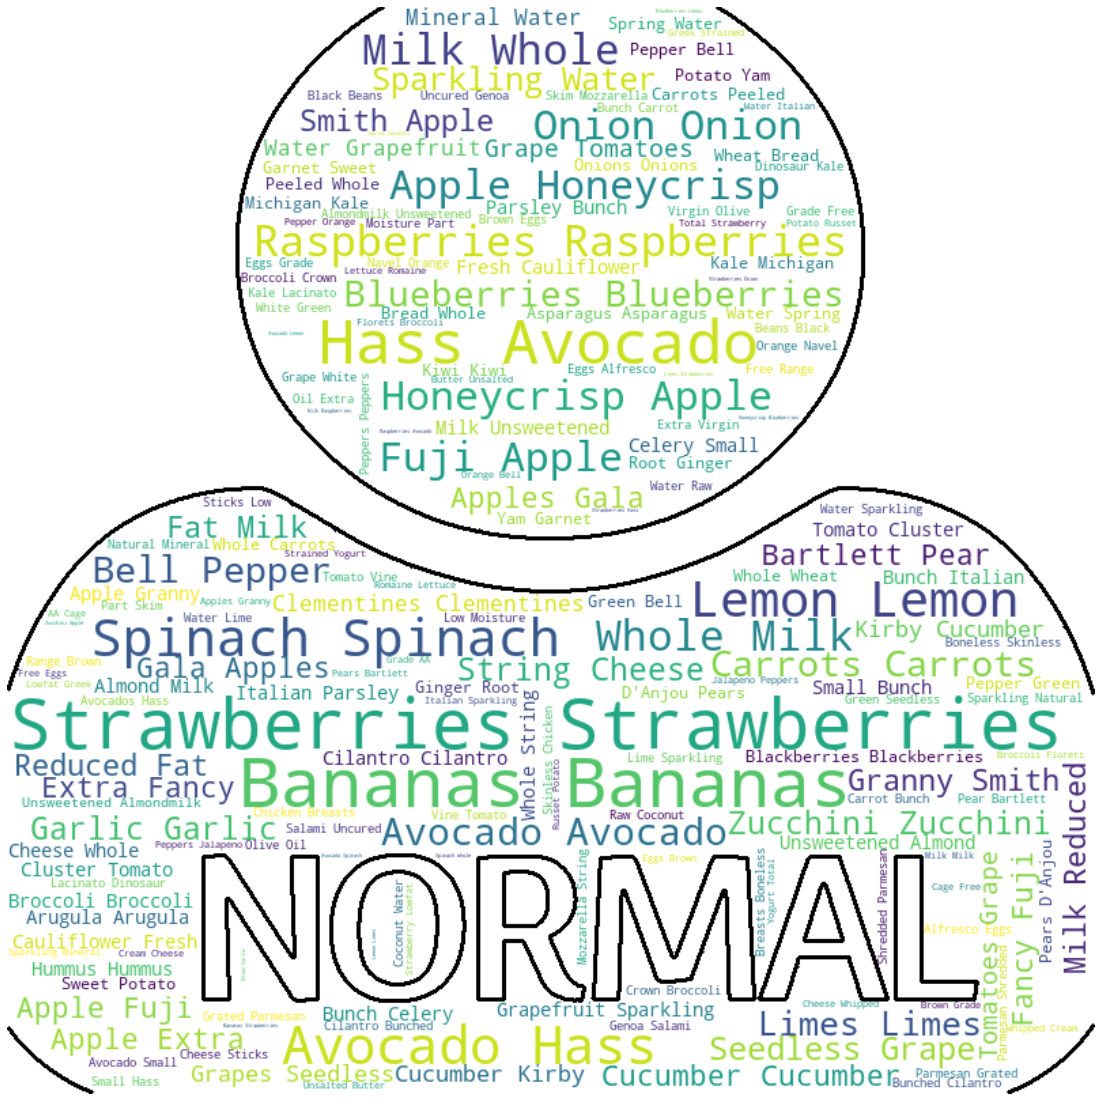

In [ ]:
# Create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(["Bag", "of", "Organic", "Baby", "Banana","Large",'Red','Half','Yellow','Original'])

plt.figure(figsize=(20,20))
# Create and generate a word cloud image:
wordcloud = WordCloud(width=800, height=800, mask=second_mask,background_color="white",
               stopwords=stopwords, contour_width=3, contour_color='black').generate(cloud_text[1])

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
_= plt.axis("off")

# 6. Segmentation


## 6.1. Customer-level Segmentation

### 6.1.1. Kmeans clustering

We'll start by converting the users data into a spark dataframe.


In [ ]:
df= spark.createDataFrame(users_stats)
df.printSchema()

root
 |-- total_orders: long (nullable = true)
 |-- dow_0: double (nullable = true)
 |-- dow_1: double (nullable = true)
 |-- dow_2: double (nullable = true)
 |-- dow_3: double (nullable = true)
 |-- dow_4: double (nullable = true)
 |-- dow_5: double (nullable = true)
 |-- dow_6: double (nullable = true)
 |-- hod_0: double (nullable = true)
 |-- hod_1: double (nullable = true)
 |-- hod_2: double (nullable = true)
 |-- hod_3: double (nullable = true)
 |-- hod_4: double (nullable = true)
 |-- hod_5: double (nullable = true)
 |-- hod_6: double (nullable = true)
 |-- hod_7: double (nullable = true)
 |-- hod_8: double (nullable = true)
 |-- hod_9: double (nullable = true)
 |-- hod_10: double (nullable = true)
 |-- hod_11: double (nullable = true)
 |-- hod_12: double (nullable = true)
 |-- hod_13: double (nullable = true)
 |-- hod_14: double (nullable = true)
 |-- hod_15: double (nullable = true)
 |-- hod_16: double (nullable = true)
 |-- hod_17: double (nullable = true)
 |-- hod_18: double 

Next we'll concatenate all user data into a single column named features. We'll use this for the kmeans clustering and finding the best value of k using the silhoutte method.

In [ ]:
#put features together into column using spark's vector assembler
vecAssembler = VectorAssembler(inputCols= users_stats.columns.values.tolist(), outputCol="features")
new_df = vecAssembler.transform(df)

In [ ]:


#find out the best k value using the silhoutte method
silhouette_scores=[]
evaluator = ClusteringEvaluator(featuresCol='features', \
metricName='silhouette', distanceMeasure='squaredEuclidean')

for K in range(2,11):

    KMeans_=SKMeans(featuresCol='features', k=K)
    KMeans_fit=KMeans_.fit(new_df)
    KMeans_transform=KMeans_fit.transform(new_df) 
    evaluation_score=evaluator.evaluate(KMeans_transform)
    silhouette_scores.append(evaluation_score)

#plot silhoutte scores
fig, ax = plt.subplots(1,1, figsize =(10,8))
ax.plot(range(2,11),silhouette_scores)
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Silhouette Score')

from the previous silhoutte plot, the local maxima is at k=3.




In [ ]:
#use k=3 to cluster user data
kmeans = SKMeans().setK(3).setSeed(1)
model = kmeans.fit(new_df.select('features'))

# Make predictions
predictions = model.transform(new_df)

# predictions.show(30)/

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

Silhouette with squared euclidean distance = 0.6792610769286944


In [ ]:
# model.save('/content/drive/MyDrive/bigdata_project/models/kmeans_model')

Now we'll examine the features of each cluster/segment.


In [ ]:
clustered_users_stats= predictions.toPandas()
clustered_users_stats.index= users_stats.index
clustered_users_stats.rename(columns = {'prediction':'segment'}, inplace = True)
clustered_users_stats.head(5)

total_orders     dow_0     dow_1     dow_2     dow_3     dow_4  \
user_id                                                                   
1                  10  0.000000  0.288136  0.152542  0.186441  0.372881   
2                  14  0.000000  0.328205  0.446154  0.148718  0.046154   
3                  12  0.522727  0.181818  0.056818  0.238636  0.000000   
4                   5  0.000000  0.000000  0.000000  0.000000  0.500000   
5                   4  0.243243  0.324324  0.000000  0.432432  0.000000   

            dow_5     dow_6  hod_0  hod_1  ...  department_other  \
user_id                                    ...                     
1        0.000000  0.000000    0.0    0.0  ...               0.0   
2        0.030769  0.000000    0.0    0.0  ...               0.0   
3        0.000000  0.000000    0.0    0.0  ...               0.0   
4        0.277778  0.222222    0.0    0.0  ...               0.0   
5        0.000000  0.000000    0.0    0.0  ...               0.0   

         department_pantry  department_personal care  department_pets  \
user_id                                                                 
1                 0.016949                  0.000000              0.0   
2                 0.056410                  0.005128              0.0   
3                 0.045455                  0.000000              0.0   
4                 0.000000                  0.000000              0.0   
5                 0.054054                  0.000000              0.0   

         department_produce  department_snacks  order_every  basket_size  \
user_id                                                                    
1                  0.084746           0.372881    18.457627     5.900000   
2                  0.184615           0.215385    14.835897    13.928571   
3                  0.431818           0.102273    10.068182     7.333333   
4                  0.111111           0.055556    11.722222     3.600000   
5                  0.513514           0.027027     9.891892     9.250000   

                                                  features  segment  
user_id                                                              
1        (10.0, 0.0, 0.288135593220339, 0.1525423728813...        0  
2        (14.0, 0.0, 0.3282051282051282, 0.446153846153...        0  
3        (12.0, 0.5227272727272727, 0.18181818181818182...        0  
4        (5.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.2777777777777...        0  
5        (4.0, 0.24324324324324326, 0.32432432432432434...        0  

[5 rows x 57 columns]

In [ ]:
clustered_users_stats.to_csv('/content/drive/MyDrive/bigdata_project/models/clustring_df')

### 6.1.2. Segment Analysis

In [ ]:
clustered_users_stats = pd.read_csv('/content/drive/MyDrive/bigdata_project/models/clustring_df')
clustered_users_stats.head()

user_id  total_orders     dow_0     dow_1     dow_2     dow_3     dow_4  \
0        1            10  0.000000  0.288136  0.152542  0.186441  0.372881   
1        2            14  0.000000  0.328205  0.446154  0.148718  0.046154   
2        3            12  0.522727  0.181818  0.056818  0.238636  0.000000   
3        4             5  0.000000  0.000000  0.000000  0.000000  0.500000   
4        5             4  0.243243  0.324324  0.000000  0.432432  0.000000   

      dow_5     dow_6  hod_0  ...  department_other  department_pantry  \
0  0.000000  0.000000    0.0  ...               0.0           0.016949   
1  0.030769  0.000000    0.0  ...               0.0           0.056410   
2  0.000000  0.000000    0.0  ...               0.0           0.045455   
3  0.277778  0.222222    0.0  ...               0.0           0.000000   
4  0.000000  0.000000    0.0  ...               0.0           0.054054   

   department_personal care  department_pets  department_produce  \
0                  0.000000              0.0            0.084746   
1                  0.005128              0.0            0.184615   
2                  0.000000              0.0            0.431818   
3                  0.000000              0.0            0.111111   
4                  0.000000              0.0            0.513514   

   department_snacks  order_every  basket_size  \
0           0.372881    18.457627     5.900000   
1           0.215385    14.835897    13.928571   
2           0.102273    10.068182     7.333333   
3           0.055556    11.722222     3.600000   
4           0.027027     9.891892     9.250000   

                                            features  segment  
0  (55,[0,2,3,4,5,15,16,17,20,22,23,24,35,36,39,4...        0  
1  (55,[0,2,3,4,5,6,17,18,19,20,23,34,35,36,38,39...        0  
2  (55,[0,1,2,3,4,22,23,24,25,26,27,35,39,40,41,4...        0  
3  (55,[0,5,6,7,19,21,23,32,34,35,38,40,42,43,51,...        0  
4  (55,[0,1,2,4,20,24,26,38,39,40,41,42,44,48,51,...        0  

[5 rows x 58 columns]

#### 6.1.2.1. Segments Distribution

First, we'll examine the percentage of customers belonging to each segment.

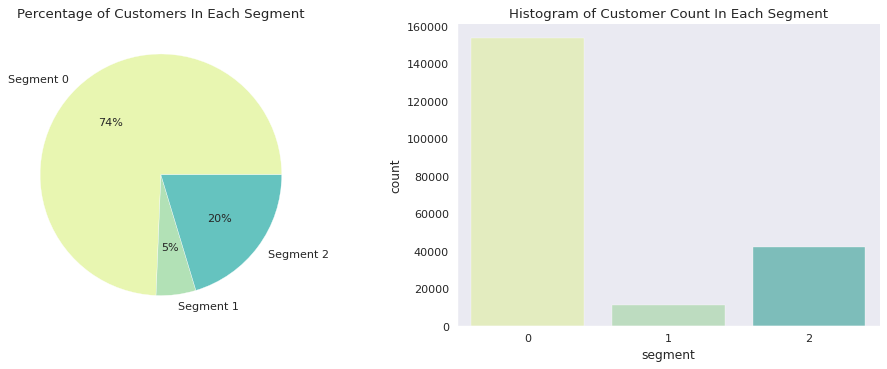

In [ ]:
#define labels
labels = ['Segment 0', 'Segment 1', 'Segment 2']
#compute counts
counts= list(clustered_users_stats.reset_index().groupby('segment').user_id.nunique())

plt.figure(figsize=(15, 5), dpi=80)
plt.rcParams.update({'axes.grid': False})

#pie plot
ax1 = plt.subplot2grid((1,2),(0,0))
ax1.set_title("Percentage of Customers In Each Segment")
plt.pie(counts, labels = labels, autopct='%.0f%%')

#bar plot
ax1 = plt.subplot2grid((1,2), (0, 1))
ax1.set_title("Histogram of Customer Count In Each Segment")
sns.countplot(x=clustered_users_stats["segment"], alpha=.9, ax=ax1)
sns.despine()

plt.show()

From the above plot, it's clear that segment 0 forms the majority of customers while segment 1 forms the minority.

#### 6.1.2.2. Loyal Customers Distribution Within Segments

As previously computed, we'll use the loyal_customers_id to find out how many loyal customers belong to each segment.

In [ ]:
#loyal_customers_id formulation
loyal_new_customers= orders_prod.drop(['product_id','add_to_cart_order','reordered','department','eval_set','order_dow','order_dow','days_since_prior_order'],axis=1).drop_duplicates()
loyal_new_customers['segment'] = loyal_new_customers['order_number'] >=30
loyal_new_customers['segment'] = loyal_new_customers['segment'].apply(lambda x: 'loyal' if x else 'normal')
loyal_customers_id = loyal_new_customers[loyal_new_customers['segment']=='loyal'].user_id.unique()
loyal_customers_id

#adding a loyalty column for the clustered_users_stats dataframe
clustered_users_stats['is_loyal']=clustered_users_stats.reset_index()['user_id'].apply(lambda x: x in loyal_customers_id)
clustered_users_stats.dropna()

user_id  total_orders     dow_0     dow_1     dow_2     dow_3  \
0             1            10  0.000000  0.288136  0.152542  0.186441   
1             2            14  0.000000  0.328205  0.446154  0.148718   
2             3            12  0.522727  0.181818  0.056818  0.238636   
3             4             5  0.000000  0.000000  0.000000  0.000000   
4             5             4  0.243243  0.324324  0.000000  0.432432   
...         ...           ...       ...       ...       ...       ...   
206204   206205             3  0.000000  0.000000  0.250000  0.000000   
206205   206206            67  0.238596  0.189474  0.115789  0.157895   
206206   206207            16  0.125561  0.192825  0.161435  0.183857   
206207   206208            49  0.081241  0.177253  0.258493  0.152142   
206208   206209            13  0.015504  0.348837  0.077519  0.263566   

           dow_4     dow_5     dow_6  hod_0  ...  department_pantry  \
0       0.372881  0.000000  0.000000    0.0  ...           0.016949   
1       0.046154  0.030769  0.000000    0.0  ...           0.056410   
2       0.000000  0.000000  0.000000    0.0  ...           0.045455   
3       0.500000  0.277778  0.222222    0.0  ...           0.000000   
4       0.000000  0.000000  0.000000    0.0  ...           0.054054   
...          ...       ...       ...    ...  ...                ...   
206204  0.531250  0.218750  0.000000    0.0  ...           0.000000   
206205  0.168421  0.035088  0.094737    0.0  ...           0.049123   
206206  0.026906  0.134529  0.174888    0.0  ...           0.067265   
206207  0.129985  0.115214  0.085672    0.0  ...           0.056130   
206208  0.108527  0.186047  0.000000    0.0  ...           0.062016   

        department_personal care  department_pets  department_produce  \
0                       0.000000              0.0            0.084746   
1                       0.005128              0.0            0.184615   
2                       0.000000              0.0            0.431818   
3                       0.000000              0.0            0.111111   
4                       0.000000              0.0            0.513514   
...                          ...              ...                 ...   
206204                  0.000000              0.0            0.218750   
206205                  0.035088              0.0            0.119298   
206206                  0.000000              0.0            0.224215   
206207                  0.007386              0.0            0.290990   
206208                  0.000000              0.0            0.147287   

        department_snacks  order_every  basket_size  \
0                0.372881    18.457627     5.900000   
1                0.215385    14.835897    13.928571   
2                0.102273    10.068182     7.333333   
3                0.055556    11.722222     3.600000   
4                0.027027     9.891892     9.250000   
...                   ...          ...          ...   
206204           0.000000     9.156250    10.666667   
206205           0.147368     3.971930     4.253731   
206206           0.103139    13.170404    13.937500   
206207           0.087149     7.292467    13.816327   
206208           0.085271    18.131783     9.923077   

                                                 features  segment  is_loyal  
0       (55,[0,2,3,4,5,15,16,17,20,22,23,24,35,36,39,4...        0     False  
1       (55,[0,2,3,4,5,6,17,18,19,20,23,34,35,36,38,39...        0     False  
2       (55,[0,1,2,3,4,22,23,24,25,26,27,35,39,40,41,4...        0     False  
3       (55,[0,5,6,7,19,21,23,32,34,35,38,40,42,43,51,...        0     False  
4       (55,[0,1,2,4,20,24,26,38,39,40,41,42,44,48,51,...        0     False  
...                                                   ...      ...       ...  
206204  (55,[0,3,5,6,20,23,24,33,34,35,39,40,42,45,46,...        0     False  
206205  [67.0,0.23859649122807017,0.18947368421052632,...        1      True  
206206  (55,[0,1,2,3,4,5,6,7,

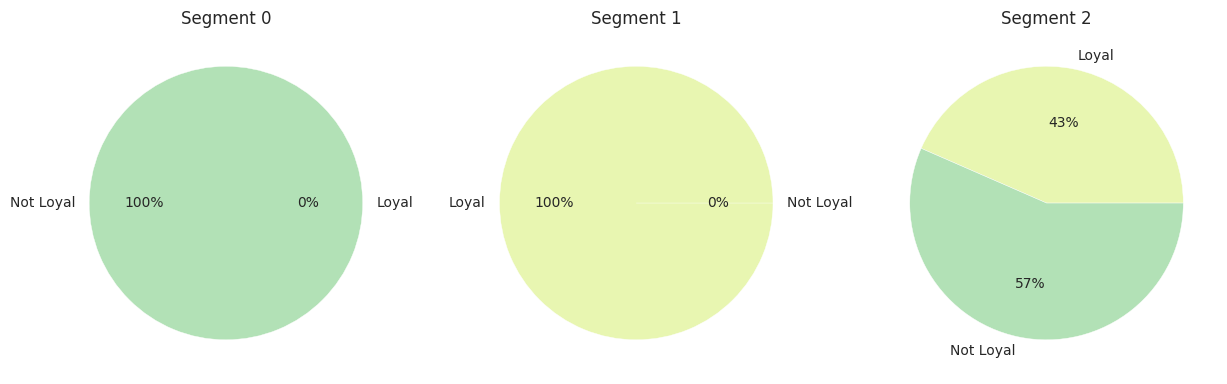

In [ ]:
#plotting the percentage of loyal customers in each segment
#define labels
labels = ['Loyal','Not Loyal']
plt.figure(figsize=(15, 10), dpi=100)

for i in range(3):
  counts= []

  #getting the data of the current segment
  d= clustered_users_stats[clustered_users_stats["segment"]==i]

  #computing counts
  counts.append(len(d[d["is_loyal"]==True]))
  counts.append(len(d[d["is_loyal"]==False]))
  
  #plotting chart
  ax1 = plt.subplot2grid((1,3),(0,i))
  ax1.set_title("Segment "+str(i))
  plt.pie(counts, labels = labels, autopct='%.0f%%')

plt.show()

From the above plot, it's clear that the percentage of loyal customers is constant among all segments, which is 14%. Hence, segment 0 has the largest number of loyal customers as it has the largest number of customers overall.

#### 6.1.2.3. Ordering Time

We'll now study when do customers from each segment make the most orders.

In [ ]:
#add a segment column to the orders dataframe to be used in the analysis
segments= []
for i in range(3):
  #storing customer ids of each segment
  segments.append(clustered_users_stats.index[clustered_users_stats["segment"]==i].tolist())
  #adding the customer segment for each order
  orders.loc[orders["user_id"].isin(segments[i]), 'segment'] = i

orders

order_id  user_id eval_set  order_number  order_dow  \
0         2539329        1    prior             1          2   
1         2398795        1    prior             2          3   
2          473747        1    prior             3          3   
3         2254736        1    prior             4          4   
4          431534        1    prior             5          4   
...           ...      ...      ...           ...        ...   
3421078   2266710   206209    prior            10          5   
3421079   1854736   206209    prior            11          4   
3421080    626363   206209    prior            12          1   
3421081   2977660   206209    prior            13          1   
3421082    272231   206209    train            14          6   

         order_hour_of_day  days_since_prior_order  segment  
0                        8                    -1.0      0.0  
1                        7                    15.0      0.0  
2                       12                    21.0      0.0  
3                        7                    29.0      0.0  
4                       15                    28.0      0.0  
...                    ...                     ...      ...  
3421078                 18                    29.0      NaN  
3421079                 10                    30.0      NaN  
3421080                 12                    18.0      NaN  
3421081                 12                     7.0      NaN  
3421082                 14                    30.0      NaN  

[3421083 rows x 8 columns]

In [ ]:
#plot the order day of week against the order hour of day for every segment
plt.figure(figsize=(5, 5), dpi=80)
for i in range(3):
  segment= orders[orders["segment"]==i]
  # Plotting a jointplot for the orders of each segment
  sns.jointplot(data=segment, x="order_dow", y="order_hour_of_day",
               shade=True, Label='Segment {}'.format(i), kind="kde",
              cmap=sns.cubehelix_palette(start=i, light=1, as_cmap=True),
              shade_lowest=False)

In [ ]:
#finding the average purchases in every day of the week for each segment
day_of_week =clustered_users_stats.groupby('segment').mean().iloc[:,1:8]
day_of_week.idxmax(axis=1)



*   Customers from segments 0 and 2 make the most orders in day 0
*   Customers from segment 1 are more active on day 1.

In [ ]:
#finding the average purchases in every hour of the day for each segment
hour_of_day =clustered_users_stats.groupby('segment').mean().iloc[:,9:32]
hour_of_day.idxmax(axis=1)


*   On average, customers from segment 0 make the most orders at 3:00 pm.
*   Customers from segments 1 and 2 make the most orders at 10:00 am.

#### 6.1.2.4. Total Orders

We'll now examine the number of orders customers make in every segment.

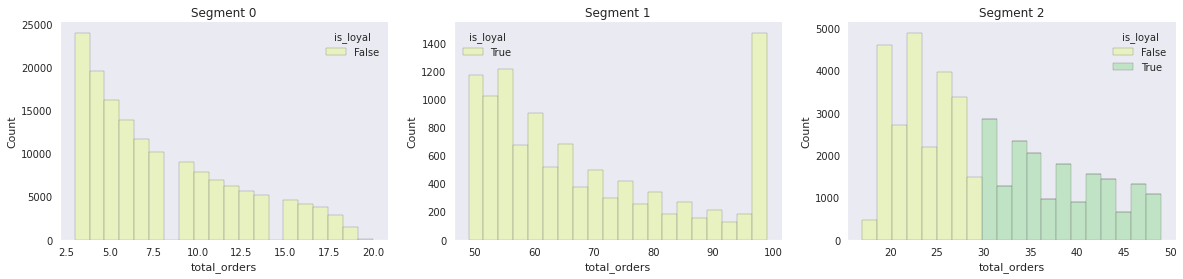

In [ ]:
plt.figure(figsize=(20, 4))

#plotting a histogram of family size showing children count in each bin
for i in range(3):
  ax1 = plt.subplot2grid((1,3),(0,i))
  ax1.set_title("Segment "+str(i))
  sns.histplot(
      clustered_users_stats[clustered_users_stats["segment"]==i],
      x="total_orders",
      hue= "is_loyal",
      multiple="stack",
      edgecolor=".4",
      bins= 20
  )
  sns.despine()

From the above plots, we can see that:
*   Even though segment 1 is the minority, they make the largest number of orders compared with the other 2 segments.
*   Segment 0 has the largest number of customers but they make the least number of orders.

#### 6.1.2.5. Ordering Frequency

Now we'll examine the ordering frequency of customers from every segment.

Segment 0 mean number of days between orders: 14.3 

Segment 1 mean number of days between orders: 5.3 

Segment 2 mean number of days between orders: 9.8 



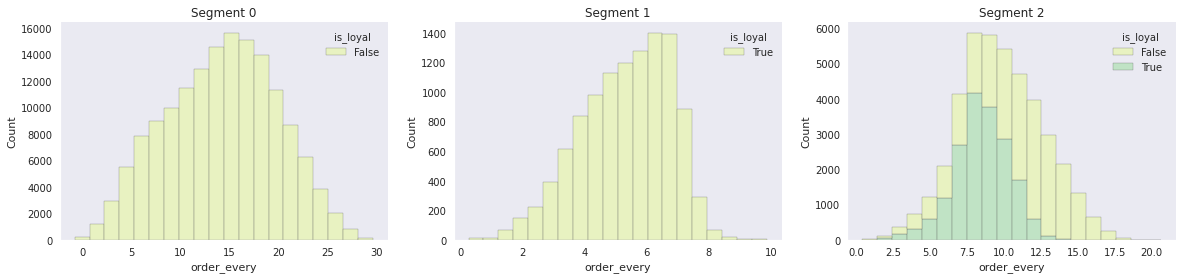

In [ ]:
plt.figure(figsize=(20, 4))

#plotting a histogram of family size showing children count in each bin
for i in range(3):
  ax1 = plt.subplot2grid((1,3),(0,i))
  ax1.set_title("Segment "+str(i))
  sns.histplot(
      clustered_users_stats[clustered_users_stats["segment"]==i],
      x="order_every",
      hue= "is_loyal",
      multiple="stack",
      edgecolor=".4",
      bins= 20
  )
  sns.despine()

  #print mean value
  print("Segment {} mean number of days between orders: {:.1f} \n".format(i,clustered_users_stats[clustered_users_stats["segment"]==i]["order_every"].mean()))

From the above plots, we can see that:
*   Segment 0 seems to have a normal distribution with a mean of 14 days between orders.
*   Segment 1 has the highest ordering frequency with a mean of 5 days between orders.
*   Segment 2 has a mean of 10 days between orders.



#### 6.1.2.6. Basket Size

We will also take a look at the basket size of each segment.

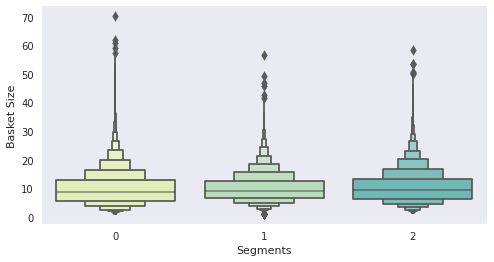

In [ ]:
plt.figure(figsize=(8, 4))

#examine the basket size of customers in different segments
segment= clustered_users_stats
sns.boxenplot(y= segment["basket_size"], x= segment["segment"],
              showfliers=True,
              ).set(xlabel="Segments", ylabel="Basket Size")
sns.despine()

All segments have very similar basket size distributions with a mean value of 10 items.

## 6.2. Product-level Segmentation

### 6.2.1. Kmeans clustering

We'll start by converting the products data into a spark dataframe.

In [ ]:
df= spark.createDataFrame(products.drop(['product_name'],axis=1))
df.printSchema()

Next we'll concatenate all product data into a single column named features. We'll use this for the kmeans clustering and finding the best value of k using the silhoutte method.

In [ ]:
#put features together into column using spark's vector assembler
vecAssembler = VectorAssembler(inputCols= products.drop(['product_name'],axis=1).columns.values.tolist(), outputCol="features")
new_df = vecAssembler.transform(df)

Text(0, 0.5, 'Silhouette Score')

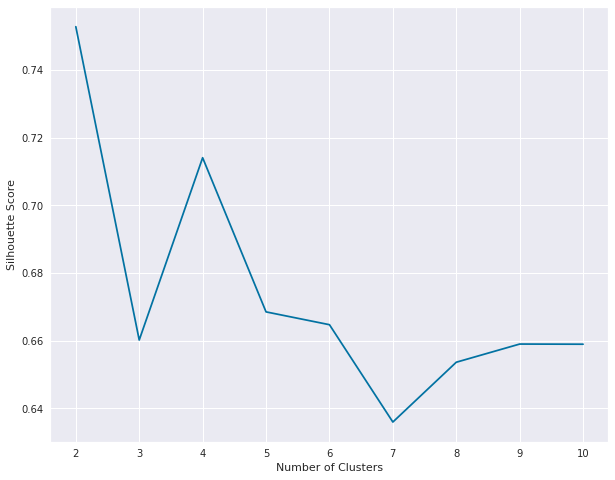

In [ ]:


#find out the best k value using the silhoutte method
silhouette_scores=[]
evaluator = ClusteringEvaluator(featuresCol='features', \
metricName='silhouette', distanceMeasure='squaredEuclidean')

for K in range(2,11):

    KMeans_=SKMeans(featuresCol='features', k=K)
    KMeans_fit=KMeans_.fit(new_df)
    KMeans_transform=KMeans_fit.transform(new_df) 
    evaluation_score=evaluator.evaluate(KMeans_transform)
    silhouette_scores.append(evaluation_score)

#plot silhoutte scores
fig, ax = plt.subplots(1,1, figsize =(10,8))
ax.plot(range(2,11),silhouette_scores,'b')
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Silhouette Score')

Now we'll cluster the products using k=3 from the above silhoutte plot.

In [ ]:
#from the previous silhoutte plot, the local maxima is at k=4
#use k=4 to cluster user data
kmeans = SKMeans().setK(3).setSeed(1)
model = kmeans.fit(new_df.select('features'))

# Make predictions
predictions = model.transform(new_df)

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))


In [ ]:
#convert spark dataframe to pandas dataframe
clustered_products= predictions.toPandas()
clustered_products.index= products.index

#add the product name column to clustered_products dataframe
clustered_products['product_name']= products['product_name']

#rename prediction column to segment
clustered_products.rename(columns = {'prediction':'segment'}, inplace = True)

#drop the features column
clustered_products= clustered_products.drop(["features"],axis=1)

#check means of each cluster
clustered_products.groupby('segment').mean()

### 6.2.2. Product Analysis

#### 6.2.2.1. Segments Distribution

First, we'll examine the percentage of products belonging to each segment.

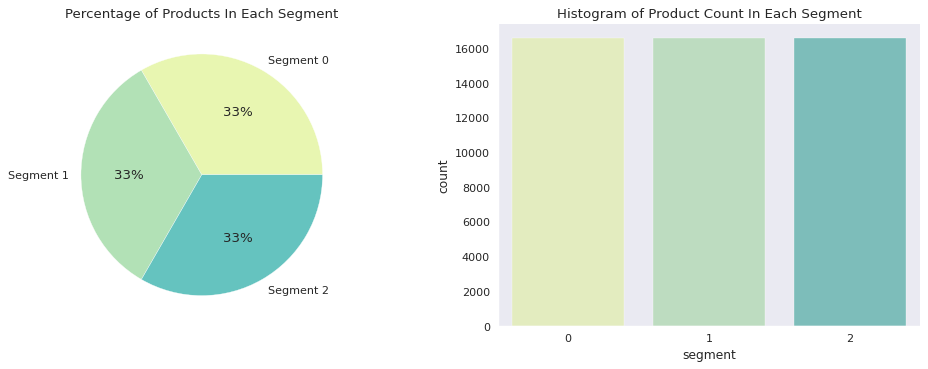

In [ ]:
sns.color_palette("rocket", as_cmap=True)

#define labels
labels = ['Segment 0', 'Segment 1', 'Segment 2']
#compute counts
counts= list(clustered_products.reset_index().groupby('segment').product_id.nunique())

plt.figure(figsize=(15, 5), dpi=80)
plt.rcParams.update({'axes.grid': False})

#pie plot
ax1 = plt.subplot2grid((1,2),(0,0))
ax1.set_title("Percentage of Products In Each Segment")
plt.pie(counts, labels = labels, autopct='%.0f%%')

#bar plot
ax1 = plt.subplot2grid((1,2), (0, 1))
ax1.set_title("Histogram of Product Count In Each Segment")
sns.countplot(x=clustered_products["segment"], alpha=.9, ax=ax1)
sns.despine()

plt.show()

#### 6.2.2.2. Ordering Time

We'll now study when do products from each segment get ordered the most.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1718: UserWarning:

`shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0.05`, but please update your code.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1213: UserWarning:

The following kwargs were not used by contour: 'Label'

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1718: UserWarning:

`shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0.05`, but please update your code.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1213: UserWarning:

The following kwargs were not used by contour: 'Label'

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1718: UserWarning:

`shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0.05`, but please update your code.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1213: UserWarning:

The following kwargs were not used by contour: 'Label'



<Figure size 400x400 with 0 Axes>

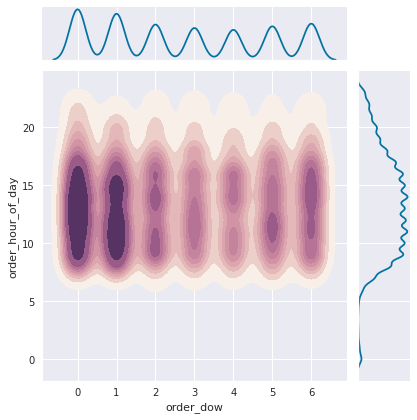

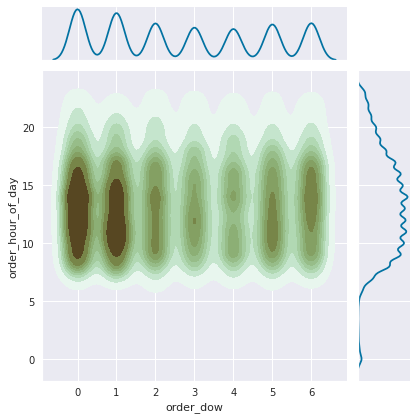

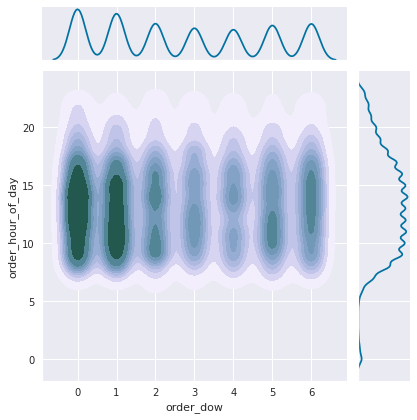

In [ ]:
#plot the product order day of week against the order hour of day for every segment
plt.figure(figsize=(5, 5), dpi=80)
for i in range(3):
  #get all orders including products belonging to current segment
  segment= orders_prod[orders_prod['product_id'].isin(clustered_products[clustered_products["segment"]==i]['product_id'].tolist())].iloc[:100000,]
  # Plotting a jointplot for the orders of each segment
  sns.jointplot(data=segment, x="order_dow", y="order_hour_of_day",
                shade=True, Label='Segment {}'.format(i), kind="kde",
              cmap=sns.cubehelix_palette(start=i, light=1, as_cmap=True),
              shade_lowest=False)

#### 6.2.2.3. Add to Cart Order

Next, we'll examine the order in which products from each segment are added to the cart.

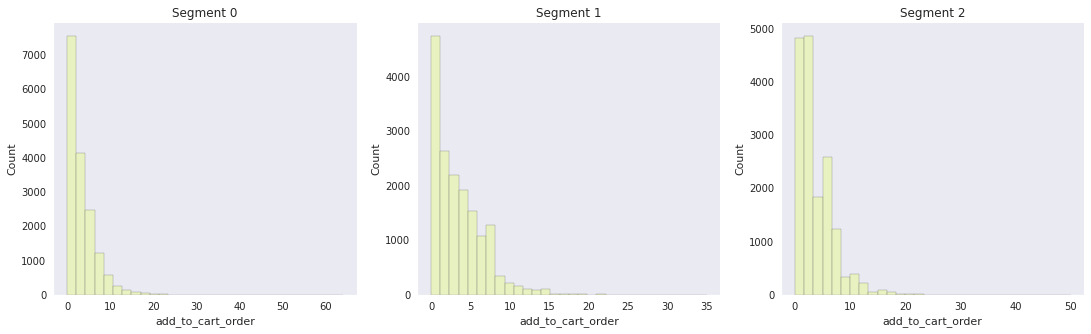

In [ ]:
plt.figure(figsize=(25, 5))

#plotting a histogram of family size showing children count in each bin
for i in range(3):
  ax1 = plt.subplot2grid((1,4),(0,i))
  ax1.set_title("Segment "+str(i))
  sns.histplot(
      clustered_products[clustered_products["segment"]==i],
      x="add_to_cart_order",
      multiple="stack",
      edgecolor=".4",
      bins= 30
  )
  sns.despine()

#### 6.2.2.4. Orders Count

Finally, we'll take a look on the frequency at which products from each segment are purchased.

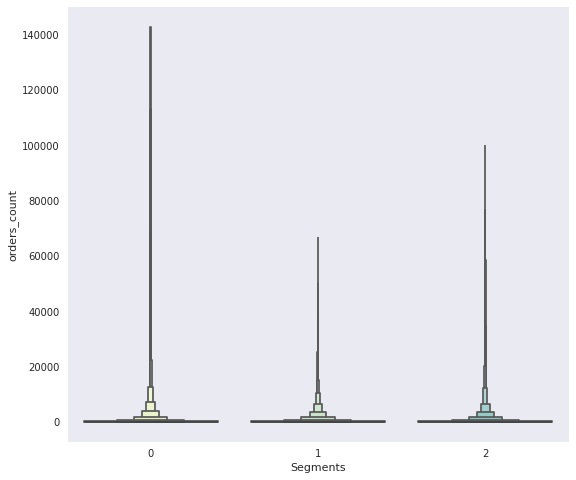

In [ ]:
plt.figure(figsize=(9, 8))

sns.boxenplot(data=clustered_products,x="segment", y="orders_count",
              showfliers=False,
              ).set(xlabel="Segments")
sns.despine()

In [ ]:
for i in range(3):
  s= clustered_products[clustered_products['segment']==i]
  percentage= len(s[s['orders_count']>20000])/len(s) *100
  print("Percentage of products in segment {} sold in more than 40,000 orders {:.2f}%".format(i,percentage))

Percentage of products in segment 0 sold in more than 40,000 orders 0.45%
Percentage of products in segment 1 sold in more than 40,000 orders 0.27%
Percentage of products in segment 2 sold in more than 40,000 orders 0.41%


# 7. Association

## 7.1.Generating rules

In [ ]:
# tansactions =  orders_prod[['order_id','product_id','user_id']]
# tansactions

In [ ]:
# transactions_segmnet_0 = tansactions[tansactions['user_id'].isin(users_segment[users_segment['segment']==0].index.values)]
# transactions_segmnet_1 = tansactions[tansactions['user_id'].isin(users_segment[users_segment['segment']==1].index.values)]
# transactions_segmnet_2 = tansactions[tansactions['user_id'].isin(users_segment[users_segment['segment']==2].index.values)]

# transactions_segmnet_0 = transactions_segmnet_0.groupby('order_id')['product_id'].apply(lambda x: x.unique()).reset_index()
# transactions_segmnet_1 = transactions_segmnet_1.groupby('order_id')['product_id'].apply(lambda x: x.unique()).reset_index()
# transactions_segmnet_2 = transactions_segmnet_2.groupby('order_id')['product_id'].apply(lambda x: x.unique()).reset_index()

# np.save('/content/drive/MyDrive/bigdata_project/transactions_segment_0.npy',transactions_segmnet_0.values)
# np.save('/content/drive/MyDrive/bigdata_project/transactions_segment_1.npy',transactions_segmnet_1.values)
# np.save('/content/drive/MyDrive/bigdata_project/transactions_segment_2.npy',transactions_segmnet_2.values)

In [ ]:
# transactions_segment_0 = np.load('/content/drive/MyDrive/bigdata_project/transactions_segment_0.npy',allow_pickle=True)
# transactions_segment_0 = pd.DataFrame(transactions_segment_0).rename(columns={0:'id',1:'items'})
# transactions_segment_0['id'] =  transactions_segment_0['id'].astype(int)
# transactions_segment_0['items'] = transactions_segment_0['items'].apply(lambda x: [int(i) for i in x])
# transactions_segment_0

# transactions_segment_1 = np.load('/content/drive/MyDrive/bigdata_project/transactions_segment_1.npy',allow_pickle=True)
# transactions_segment_1 = pd.DataFrame(transactions_segment_1).rename(columns={0:'id',1:'items'})
# transactions_segment_1['id'] =  transactions_segment_1['id'].astype(int)
# transactions_segment_1['items'] = transactions_segment_1['items'].apply(lambda x: [int(i) for i in x])
# transactions_segment_1

transactions_segment_2 = np.load('/content/drive/MyDrive/bigdata_project/transactions_segment_2.npy',allow_pickle=True)
transactions_segment_2 = pd.DataFrame(transactions_segment_2).rename(columns={0:'id',1:'items'})
transactions_segment_2['id'] =  transactions_segment_2['id'].astype(int)
transactions_segment_2['items'] = transactions_segment_2['items'].apply(lambda x: [int(i) for i in x])
transactions_segment_2

id                                              items
0              3  [33754, 24838, 17704, 21903, 17668, 46667, 174...
1              8                                            [23423]
2              9  [21405, 47890, 11182, 2014, 29193, 34203, 1499...
3             10  [24852, 4796, 31717, 47766, 4605, 1529, 21137,...
4             12  [30597, 15221, 43772, 37886, 37215, 34335, 316...
...          ...                                                ...
1244693  3421075  [49429, 18721, 34027, 14227, 25153, 43409, 479...
1244694  3421077                       [27966, 45007, 26940, 27845]
1244695  3421080  [27845, 4932, 18811, 41950, 31717, 12935, 2512...
1244696  3421082  [17279, 12738, 16797, 43352, 32700, 12023, 47941]
1244697  3421083  [7854, 45309, 21162, 18176, 35211, 39678, 1135...

[1244698 rows x 2 columns]

In [ ]:
#put the pandas dataframe you create inside this function
df= spark.createDataFrame(transactions_segment_2,schema= StructType([StructField("id", IntegerType()),StructField("items", ArrayType(IntegerType()))]))



In [ ]:
fpGrowth = FPGrowth(itemsCol="items", minSupport=0.0005, minConfidence=0.01)
model = fpGrowth.fit(df)



In [ ]:
# #save frequent itemsets.
# freqItemSets= model.freqItemsets.toPandas()

# #save generated association rules.
# associationRules= model.associationRules.toPandas()

# # transform examines the input items against all the association rules and summarize the
# # consequents as prediction
# transformedDf= model.transform(df).toPandas()

# #display output
# display(freqItemSets)
# print("\n")
# display(associationRules)
# # print("\n")
# # display(transformedDf)

model.freqItemsets.show()

/content/spark-3.2.1-bin-hadoop3.2/python/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


+--------------+-----+
|         items| freq|
+--------------+-----+
|       [21527]|  653|
|        [1787]|  741|
|       [24288]|  732|
|       [48123]|  651|
|       [17400]|  831|
|       [21769]|  967|
|       [10006]|  963|
|       [14127]| 1134|
|       [46676]|10395|
|[46676, 26209]|  814|
|[46676, 21137]| 1165|
|[46676, 47766]| 1152|
|[46676, 47209]|  998|
|[46676, 16797]|  700|
|[46676, 13176]| 1405|
|[46676, 21903]| 1246|
|[46676, 47626]|  941|
|[46676, 24852]| 2851|
|        [2124]|  709|
|       [33956]| 1131|
+--------------+-----+
only showing top 20 rows



In [ ]:
model.associationRules.show()

/content/spark-3.2.1-bin-hadoop3.2/python/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


+--------------+----------+-------------------+------------------+--------------------+
|    antecedent|consequent|         confidence|              lift|             support|
+--------------+----------+-------------------+------------------+--------------------+
|       [17652]|   [21137]| 0.2567020738492666|2.9629585199517274|8.154588502592597E-4|
|       [17652]|   [13176]|0.20763783510369246|1.6679126315110215| 6.59597749815618E-4|
|       [17652]|   [24852]| 0.2832574607991907| 1.810548885086766|8.998166623550452E-4|
|[39877, 47626]|   [24852]| 0.3016135705419942|1.9278790127225718| 5.85684238265025E-4|
|       [14233]|   [13176]| 0.1563990082014114|1.2563215235058622|6.587943420813723E-4|
|[27104, 26209]|   [21903]|0.23905723905723905| 3.004413083129548| 5.70419491314359E-4|
|[27104, 26209]|   [47626]| 0.2447811447811448| 4.941348405695866|5.840774227965338E-4|
|[27104, 26209]|   [24852]| 0.2787878787878788|  1.78197983449741|6.652216039553369E-4|
|[27104, 26209]|   [24964]|0.214

In [ ]:
model.freqItemsets.count()

/content/spark-3.2.1-bin-hadoop3.2/python/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


11792

In [ ]:
model.associationRules.count()

/content/spark-3.2.1-bin-hadoop3.2/python/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


17002

In [ ]:
np.save('/content/drive/MyDrive/bigdata_project/freqItemsets_segment_2.npy',np.array(model.freqItemsets.collect()))

/content/spark-3.2.1-bin-hadoop3.2/python/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


In [ ]:
np.save('/content/drive/MyDrive/bigdata_project/associationRules_segment_2.npy',np.array(model.associationRules.collect()))

/content/spark-3.2.1-bin-hadoop3.2/python/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


## 7.2. Rules visualization

In [ ]:
segment_label = 'segment_2'

In [ ]:
frequencies = pd.DataFrame(np.load(f'/content/drive/MyDrive/bigdata_project/freqItemsets_{segment_label}.npy',allow_pickle=True)).rename(columns={0:'items',1:'freq'})
rules = pd.DataFrame(np.load(f'/content/drive/MyDrive/bigdata_project/associationRules_{segment_label}.npy',allow_pickle=True)).rename(columns={0:'antecedent',1:'consequent',2:'confidence',3:'lift',4:'support'})

In [ ]:
freq_mapper = frequencies[frequencies['items'].apply(lambda x: len(x) == 1)]
freq_mapper['items'] = freq_mapper['items'].apply(lambda x: x[0])
#freq_mapper['items'] = mapper.loc[freq_mapper['items']].values
freq_mapper = freq_mapper.set_index('items')
freq_mapper.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



freq
items     
21527  653
1787   741
24288  732
48123  651
17400  831

In [ ]:
rules['confidence'] = rules['confidence'].astype(np.float32)
rules['lift'] = rules['lift'].astype(np.float32)
rules['support'] = rules['support'].astype(np.float32)
rules.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17002 entries, 0 to 17001
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   antecedent  17002 non-null  object 
 1   consequent  17002 non-null  object 
 2   confidence  17002 non-null  float32
 3   lift        17002 non-null  float32
 4   support     17002 non-null  float32
dtypes: float32(3), object(2)
memory usage: 465.0+ KB


In [ ]:
rules['antecedent'].apply(lambda x: len(x)).value_counts()

1    11522
2     5316
3      164
Name: antecedent, dtype: int64

In [ ]:
only_three_rules = rules[rules['antecedent'].apply(lambda x: len(x) == 2)]
only_three_rules.head()

antecedent consequent  confidence      lift   support
3  [39877, 47626]    [24852]    0.301614  1.927879  0.000586
5  [27104, 26209]    [21903]    0.239057  3.004413  0.000570
6  [27104, 26209]    [47626]    0.244781  4.941349  0.000584
7  [27104, 26209]    [24852]    0.278788  1.781980  0.000665
8  [27104, 26209]    [24964]    0.214815  5.920323  0.000513

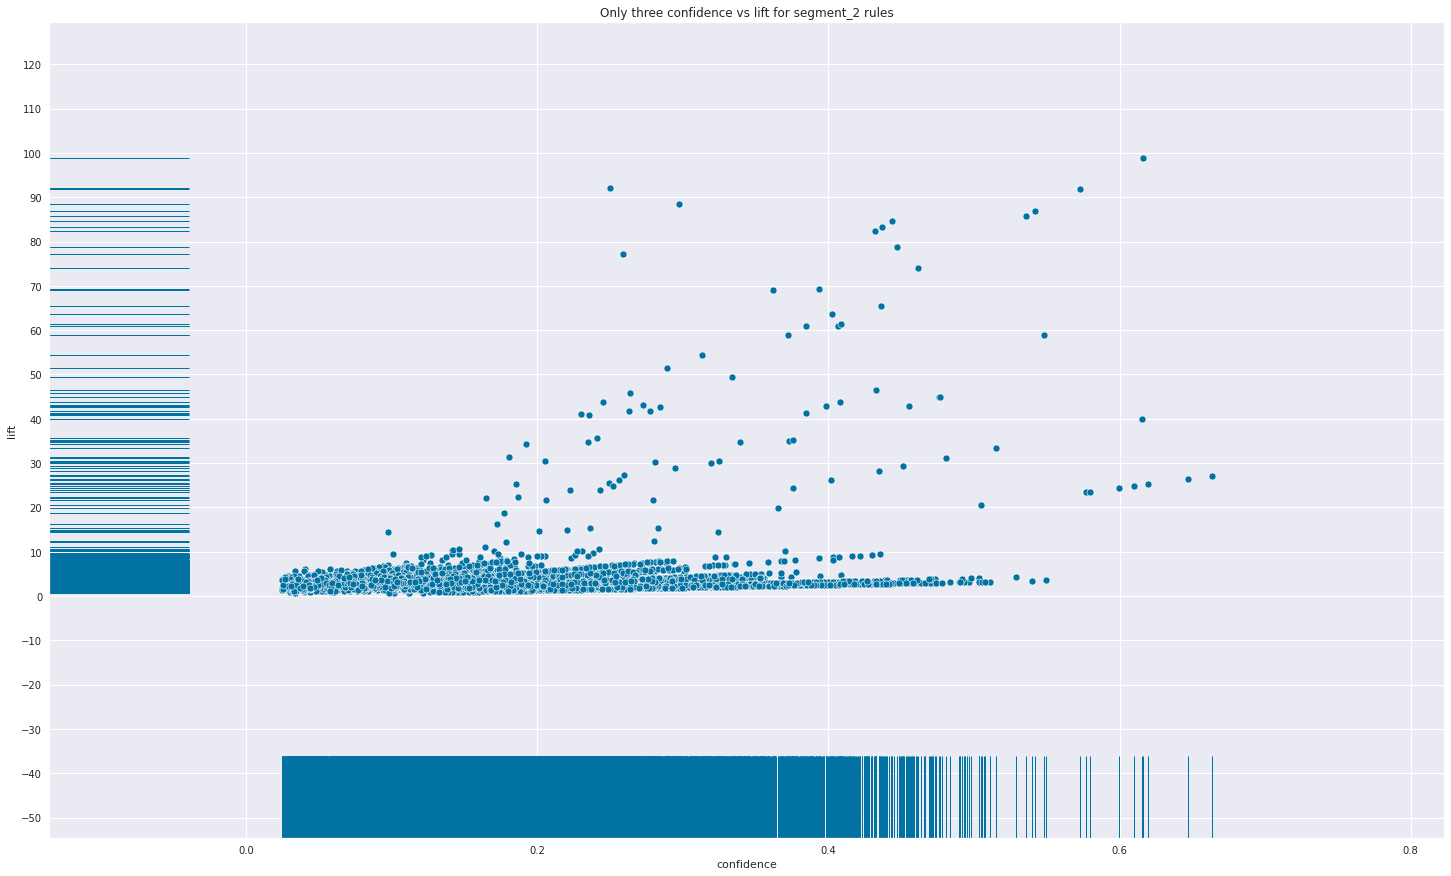

In [ ]:
plt.figure(figsize=(25,15))
sns.scatterplot(data=only_three_rules, x="confidence", y="lift")
sns.rugplot(data=only_three_rules, x="confidence", y="lift", height=.1)
plt.yticks(np.arange(-50,126,10))
_=plt.title(f'Only three confidence vs lift for {segment_label} rules')

In [ ]:
filterd_only_three_rules = only_three_rules[(only_three_rules['confidence'] >= 0.1) & (only_three_rules['lift'] >= 3)]
filterd_only_three_rules.head()

antecedent consequent  confidence      lift   support
5   [27104, 26209]    [21903]    0.239057  3.004413  0.000570
6   [27104, 26209]    [47626]    0.244781  4.941349  0.000584
8   [27104, 26209]    [24964]    0.214815  5.920323  0.000513
10  [39275, 45007]    [21137]    0.284287  3.281355  0.000503
30   [5785, 27966]    [21137]    0.324373  3.744041  0.000582

In [ ]:
filterd_only_three_rules

antecedent consequent  confidence      lift   support
5      [27104, 26209]    [21903]    0.239057  3.004413  0.000570
6      [27104, 26209]    [47626]    0.244781  4.941349  0.000584
8      [27104, 26209]    [24964]    0.214815  5.920323  0.000513
10     [39275, 45007]    [21137]    0.284287  3.281355  0.000503
30      [5785, 27966]    [21137]    0.324373  3.744041  0.000582
...               ...        ...         ...       ...       ...
16992  [34126, 13176]    [21903]    0.239723  3.012781  0.000890
16993  [34126, 13176]    [24964]    0.211597  5.831632  0.000786
16995  [27966, 26209]    [21137]    0.292479  3.375911  0.000928
16996  [27966, 26209]    [47209]    0.271968  3.883774  0.000863
16999  [27966, 26209]    [47626]    0.171183  3.455629  0.000543

[1968 rows x 5 columns]

In [ ]:
mapper = products.set_index('product_id').drop(['aisle_id','department_id'],axis=1)
mapper.head()

product_name
product_id                                                   
1                                  Chocolate Sandwich Cookies
2                                            All-Seasons Salt
3                        Robust Golden Unsweetened Oolong Tea
4           Smart Ones Classic Favorites Mini Rigatoni Wit...
5                                   Green Chile Anytime Sauce

In [ ]:
vis_df = filterd_only_three_rules.copy()
vis_df['1st'] = vis_df['antecedent'].apply(lambda x: x[0])
vis_df['2nd'] = vis_df['antecedent'].apply(lambda x: x[1])
vis_df.rename(columns={'consequent':'3rd'},inplace=True)
vis_df['3rd']=vis_df['3rd'].apply(lambda x: x[0])
 
vis_df.drop(['antecedent','confidence','support'],axis=1,inplace=True)
vis_df = vis_df[['1st','2nd','3rd','lift']]

 
for col in vis_df.columns[:-1]:
    vis_df[col] = vis_df[col].apply(lambda x: mapper.loc[x].values[0]).astype(str)

vis_df.head()

1st                  2nd                   3rd  \
5             Fresh Cauliflower                Limes  Organic Baby Spinach   
6             Fresh Cauliflower                Limes           Large Lemon   
8             Fresh Cauliflower                Limes        Organic Garlic   
10          Organic Blueberries     Organic Zucchini  Organic Strawberries   
30  Organic Reduced Fat 2% Milk  Organic Raspberries  Organic Strawberries   

        lift  
5   3.004413  
6   4.941349  
8   5.920323  
10  3.281355  
30  3.744041

In [ ]:


percentiles = vis_df.lift.describe()
vis_df['type'] = vis_df.lift.apply(lambda x: '#EB5353' if x < percentiles['25%'] else '#F9D923' if x < percentiles['50%'] else '#36AE7C')

fig = px.parallel_categories(vis_df.drop(columns='lift'),color='type',dimensions=['1st','2nd','3rd'],title=f'Three items rules {segment_label} (Green: High lift, Yellow: Mid lift, Red: low lift)',color_continuous_scale=['#EB5353','#F9D923','#36AE7C'])
fig.update_layout(
    autosize=False,
    width=1750,
    height=7500,
    margin=dict(
        l=250,
        r=250,
        b=10,
        pad=100
    ),
    font=dict(
        size=17,
        color='black'
    ),
    boxmode='group', 
    boxgap=1,
    boxgroupgap=1
    )



fig.show()
fig.write_html('/content/drive/MyDrive/bigdata_project/plots/'+f"{segment_label}_threes_affinity.html")

In [ ]:
only_two_rules = rules[rules['antecedent'].apply(lambda x: len(x) == 1)]
only_two_rules.head()



antecedent consequent  confidence      lift   support
0    [17652]    [21137]    0.256702  2.962959  0.000815
1    [17652]    [13176]    0.207638  1.667913  0.000660
2    [17652]    [24852]    0.283257  1.810549  0.000900
4    [14233]    [13176]    0.156399  1.256322  0.000659
9    [13733]    [24852]    0.278912  1.782770  0.000922

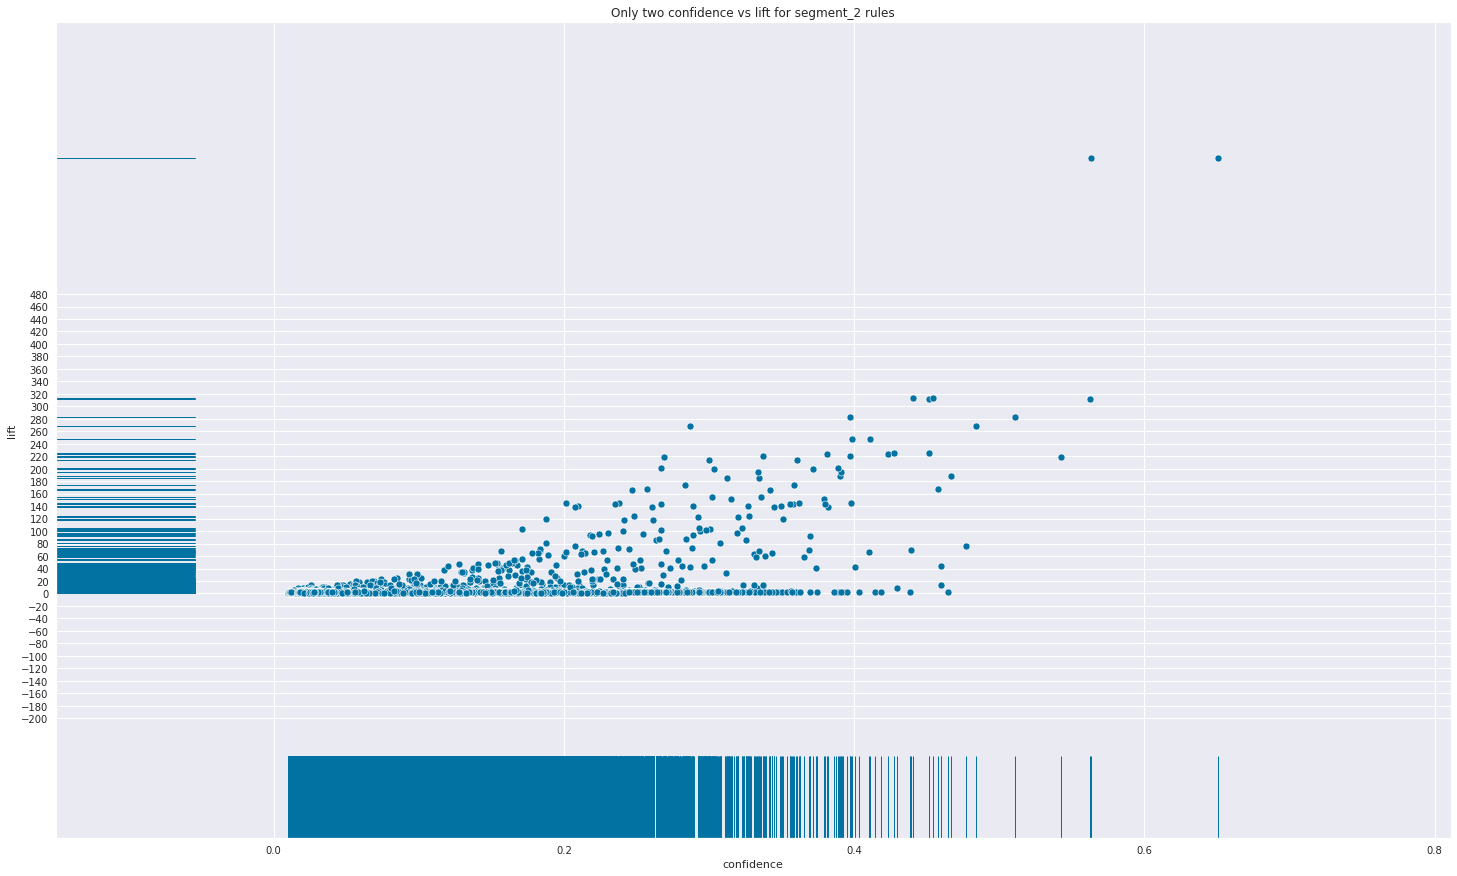

In [ ]:
plt.figure(figsize=(25,15))
sns.scatterplot(data=only_two_rules, x="confidence", y="lift")
sns.rugplot(data=only_two_rules, x="confidence", y="lift", height=.1)
plt.yticks(np.arange(-200,500,20))

_=plt.title(f'Only two confidence vs lift for {segment_label} rules')

In [ ]:
filterd_only_two_rules = only_two_rules[(only_two_rules['confidence'] >= 0.1) & (only_two_rules['lift'] >= 3)]
filterd_only_two_rules.loc[:,'antecedent'] = filterd_only_two_rules['antecedent'].apply(lambda x: x[0])
filterd_only_two_rules.loc[:,'consequent'] = filterd_only_two_rules['consequent'].apply(lambda x: x[0])
filterd_only_two_rules

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



antecedent  consequent  confidence        lift   support
58          49520       44632    0.168207    6.841597  0.000790
59          49520       35221    0.144593    9.399609  0.000679
60          49520       21709    0.150582   14.165888  0.000707
81          23291       35633    0.398544  248.405869  0.000660
100          7969       47626    0.189125    3.817835  0.000578
...           ...         ...         ...         ...       ...
16896       35221       21709    0.178775   16.818121  0.002750
16904       28553        9076    0.204211   11.154625  0.000623
16907       30192        5491    0.483822  268.845001  0.000517
16944       26604       27966    0.165557    3.752360  0.003376
16957       26604       39275    0.100075    3.130746  0.002041

[711 rows x 5 columns]

In [ ]:
mapped_items = {}
for item in filterd_only_two_rules.antecedent.unique():
  df_item = filterd_only_two_rules[filterd_only_two_rules['antecedent']==item]
  df_item['antecedent'] = mapper.loc[df_item['antecedent']].values
  df_item['consequent'] = mapper.loc[df_item['consequent']].values
  mapped_items[df_item.iloc[0].antecedent] = {'freq':freq_mapper.loc[item].values[0],
                        'items':df_item[['consequent','confidence']].values.tolist()}

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
G = nx.Graph() #nx.spring_layout(G)

for key,val in mapped_items.items():
  G.add_nodes_from([
          (key,{'freq':val['freq']})
      ])
  for item,conf in val['items']:
    try:
      G.add_nodes_from([
          (item,{'freq':freq_mapper.loc[item].values[0]})
      ])
    except:
      G.add_nodes_from([
          (item,{'freq':'<200'})
      ])
    G.add_edge(key,item)

  

In [ ]:
pos = nx.spring_layout(G)

In [ ]:
edge_x = []
edge_y = []
edge_text = []
for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)
    # print(edge[0])
    # for item,conf in mapped_items[edge[0]]['items']:
    #     if item != edge[1]:
    #         continue
    #     edge_text.append('({} -> {}), Confidence:{:.2f}'.format(edge[0],edge[1],conf))

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='text',
    mode='lines')

edge_trace.text = edge_text

node_x = []
node_y = []
for x,y in pos.values():
    node_x.append(x)
    node_y.append(y)

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        # colorscale options
        #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
        #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
        #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
        colorscale=[[0, "rgb(235, 83, 83)"],
                [0.25, "rgb(249, 217, 35)"],
                [0.5, "rgb(54, 174, 124)"],
                [0.75, "rgb(24, 116, 152)"],
                [1, "rgb(7, 40, 54)"]],
        reversescale=True,
        color=[],
        size=10,
        colorbar=dict(
            thickness=15,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        line_width=2))

node_color = []
node_text = []
for item in pos.keys():
    node_color.append(np.random.randint(100))
    node_text.append('{}, freq:{:.2f}'.format(item,G.nodes[item]['freq']) if not isinstance(G.nodes[item]['freq'],str) else '{}, freq:{}'.format(item,G.nodes[item]['freq']))

node_trace.text = node_text
node_trace.marker.color = node_color


In [ ]:
fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title=f'<br>Affinity Network for {segment_label}',
                titlefont_size=18,
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                )
            
fig.show()

fig.write_html('/content/drive/MyDrive/bigdata_project/plots/'+f"{segment_label}_affinity_unique_transaction_network.html")

## 7.3. Rules information extraction

In [ ]:
segment_label = 'segment_0'

In [ ]:
frequencies = pd.DataFrame(np.load(f'/content/drive/MyDrive/bigdata_project/freqItemsets_{segment_label}.npy',allow_pickle=True)).rename(columns={0:'items',1:'freq'})
rules = pd.DataFrame(np.load(f'/content/drive/MyDrive/bigdata_project/associationRules_{segment_label}.npy',allow_pickle=True)).rename(columns={0:'antecedent',1:'consequent',2:'confidence',3:'lift',4:'support'})

In [ ]:
rules['confidence'] = rules['confidence'].astype(np.float32)
rules['lift'] = rules['lift'].astype(np.float32)
rules['support'] = rules['support'].astype(np.float32)
rules.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11011 entries, 0 to 11010
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   antecedent  11011 non-null  object 
 1   consequent  11011 non-null  object 
 2   confidence  11011 non-null  float32
 3   lift        11011 non-null  float32
 4   support     11011 non-null  float32
dtypes: float32(3), object(2)
memory usage: 301.2+ KB


In [ ]:
freq_mapper = frequencies[frequencies['items'].apply(lambda x: len(x) == 1)]
freq_mapper['items'] = freq_mapper['items'].apply(lambda x: x[0])
#freq_mapper['items'] = mapper.loc[freq_mapper['items']].values
freq_mapper = freq_mapper.set_index('items')
freq_mapper.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



freq
items     
14488  635
40541  714
34854  705
26586  632
13640  804

In [ ]:
mapper = products.set_index('product_id').drop(['aisle_id','department_id'],axis=1)
mapper.head()

product_name
product_id                                                   
1                                  Chocolate Sandwich Cookies
2                                            All-Seasons Salt
3                        Robust Golden Unsweetened Oolong Tea
4           Smart Ones Classic Favorites Mini Rigatoni Wit...
5                                   Green Chile Anytime Sauce

### 7.3.1 Often bought with 

In [ ]:
only_two_rules = rules[rules['antecedent'].apply(lambda x: len(x) == 1)]
only_two_rules.head()

antecedent consequent  confidence      lift   support
0    [17652]    [21137]    0.256702  2.962959  0.000815
1    [17652]    [13176]    0.207638  1.667913  0.000660
2    [17652]    [24852]    0.283257  1.810549  0.000900
4    [14233]    [13176]    0.156399  1.256322  0.000659
9    [13733]    [24852]    0.278912  1.782770  0.000922

In [ ]:
only_two_rules.support.describe()

count    11522.000000
mean         0.001198
std          0.001250
min          0.000501
25%          0.000612
50%          0.000811
75%          0.001267
max          0.021036
Name: support, dtype: float64

In [ ]:
only_two_rules.confidence.describe()

count    11522.000000
mean         0.084801
std          0.076350
min          0.010010
25%          0.029627
50%          0.054890
75%          0.120017
max          0.650746
Name: confidence, dtype: float64

In [ ]:
only_two_rules.lift.describe()

count    11522.000000
mean         4.106221
std         18.040524
min          0.457195
25%          1.609103
50%          2.040819
75%          2.664235
max        697.659424
Name: lift, dtype: float64

In [ ]:
MIN_SUPPORT = 0
MIN_LIFT = 0
MIN_CONF = 0

MAX_GROUP_SIZE = 5

In [ ]:
only_two_rules['antecedent'] = only_two_rules['antecedent'].apply(lambda x: x[0]) 
only_two_rules['consequent'] = only_two_rules['consequent'].apply(lambda x: x[0]) 
only_two_rules.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



antecedent  consequent  confidence      lift   support
0       17652       21137    0.256702  2.962959  0.000815
1       17652       13176    0.207638  1.667913  0.000660
2       17652       24852    0.283257  1.810549  0.000900
4       14233       13176    0.156399  1.256322  0.000659
9       13733       24852    0.278912  1.782770  0.000922

In [ ]:
filterd_only_two_rules= only_two_rules[(only_two_rules['confidence']>=MIN_CONF)&(only_two_rules['lift']>=MIN_LIFT)&(only_two_rules['support']>=MIN_SUPPORT)]
filterd_only_two_rules

antecedent  consequent  confidence      lift   support
0           17652       21137    0.256702  2.962959  0.000815
1           17652       13176    0.207638  1.667913  0.000660
2           17652       24852    0.283257  1.810549  0.000900
4           14233       13176    0.156399  1.256322  0.000659
9           13733       24852    0.278912  1.782770  0.000922
...           ...         ...         ...       ...       ...
16970       26604       39928    0.050392  3.029797  0.001028
16971       26604       41787    0.027737  2.280353  0.000566
16972       26604       34126    0.027225  1.354505  0.000555
16973       26604       21938    0.028052  1.550345  0.000572
17001       35233       24852    0.270697  1.730264  0.000565

[11522 rows x 5 columns]

In [ ]:
often_bought_with = {}
for item in filterd_only_two_rules.antecedent.unique():
  item_df = filterd_only_two_rules[filterd_only_two_rules['antecedent'] == item][['consequent','confidence']].sort_values('confidence',ascending=False)
  item_df['consequent'] = mapper.loc[item_df['consequent'].values].values
  often_bought_with[mapper.loc[item].values[0]] = item_df.values.tolist()[:MAX_GROUP_SIZE]

In [ ]:
with open("/content/drive/MyDrive/bigdata_project/output/{}_often_bought_with_result.json".format(segment_label), "w") as fp:
  json.dump(often_bought_with, fp, indent=4)
  print(
      "Operation completed: Result has {} product groups saved to /content/drive/MyDrive/bigdata_project/output/{}_often_bought_with_result.json\n\n\n".format(
          len(often_bought_with), segment_label
      )
  )

Operation completed: Result has 838 product groups saved to /content/drive/MyDrive/bigdata_project/output/segment_2_often_bought_with_result.json





### 7.3.2 Offer groups

In [ ]:
only_two_rules = rules[rules['antecedent'].apply(lambda x: len(x) == 1)]
only_two_rules.head()

antecedent consequent  confidence      lift   support
0    [17652]    [21137]    0.256702  2.962959  0.000815
1    [17652]    [13176]    0.207638  1.667913  0.000660
2    [17652]    [24852]    0.283257  1.810549  0.000900
4    [14233]    [13176]    0.156399  1.256322  0.000659
9    [13733]    [24852]    0.278912  1.782770  0.000922

In [ ]:
only_two_rules.support.describe()

count    11522.000000
mean         0.001198
std          0.001250
min          0.000501
25%          0.000612
50%          0.000811
75%          0.001267
max          0.021036
Name: support, dtype: float64

In [ ]:
only_two_rules.confidence.describe()

count    11522.000000
mean         0.084801
std          0.076350
min          0.010010
25%          0.029627
50%          0.054890
75%          0.120017
max          0.650746
Name: confidence, dtype: float64

In [ ]:
only_two_rules.lift.describe()

count    11522.000000
mean         4.106221
std         18.040524
min          0.457195
25%          1.609103
50%          2.040819
75%          2.664235
max        697.659424
Name: lift, dtype: float64

In [ ]:
MIN_SUPPORT = 0
MIN_LIFT = 0
MIN_CONF = 0

MAX_GROUP_SIZE = 5

In [ ]:
only_two_rules['antecedent'] = only_two_rules['antecedent'].apply(lambda x: x[0]) 
only_two_rules['consequent'] = only_two_rules['consequent'].apply(lambda x: x[0]) 
only_two_rules.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



antecedent  consequent  confidence      lift   support
0       17652       21137    0.256702  2.962959  0.000815
1       17652       13176    0.207638  1.667913  0.000660
2       17652       24852    0.283257  1.810549  0.000900
4       14233       13176    0.156399  1.256322  0.000659
9       13733       24852    0.278912  1.782770  0.000922

In [ ]:
filterd_only_two_rules= only_two_rules[(only_two_rules['confidence']>=MIN_CONF)&(only_two_rules['lift']>=MIN_LIFT)&(only_two_rules['support']>=MIN_SUPPORT)]
filterd_only_two_rules

antecedent  consequent  confidence      lift   support
0           17652       21137    0.256702  2.962959  0.000815
1           17652       13176    0.207638  1.667913  0.000660
2           17652       24852    0.283257  1.810549  0.000900
4           14233       13176    0.156399  1.256322  0.000659
9           13733       24852    0.278912  1.782770  0.000922
...           ...         ...         ...       ...       ...
16970       26604       39928    0.050392  3.029797  0.001028
16971       26604       41787    0.027737  2.280353  0.000566
16972       26604       34126    0.027225  1.354505  0.000555
16973       26604       21938    0.028052  1.550345  0.000572
17001       35233       24852    0.270697  1.730264  0.000565

[11522 rows x 5 columns]

In [ ]:
offer_groups = {}
freq_items = freq_mapper.index.values.tolist()
for item in filterd_only_two_rules.antecedent.unique():
  item_df = filterd_only_two_rules[filterd_only_two_rules['antecedent'] == item][['consequent','lift']].sort_values('lift',ascending=False)
  items_set = [item]
  items_set += list(item_df['consequent'].unique())
  item_df['consequent'] = mapper.loc[item_df['consequent'].values].values
  offer_groups[mapper.loc[item].values[0]] = {'items':item_df.values.tolist()[:MAX_GROUP_SIZE],
                                                   'group_score': np.mean([np.log1p(freq_mapper.loc[item].values[0]) if item in freq_items else 0 for item in items_set])}

In [ ]:
with open("/content/drive/MyDrive/bigdata_project/output/{}_offer_groups.json".format(segment_label), "w") as fp:
  json.dump(offer_groups, fp, indent=4)
  print(
      "Operation completed: Result has {} product groups saved to /content/drive/MyDrive/bigdata_project/output/{}_offer_groups.json\n\n\n".format(
          len(offer_groups), segment_label
      )
  )

Operation completed: Result has 838 product groups saved to /content/drive/MyDrive/bigdata_project/output/segment_2_offer_groups.json





### 7.3.3 The general rules

In [ ]:
rules['antecedent'] = rules['antecedent'].apply(lambda x: x[0] if (isinstance(x,list) or isinstance(x,tuple)) and len(x) == 1 else tuple(x) if (isinstance(x,list) or isinstance(x,tuple)) else x)
rules['consequent'] = rules['consequent'].apply(lambda x: x[0] if (isinstance(x,list) or isinstance(x,tuple)) else x)
rules.head()

antecedent  consequent  confidence      lift   support
0  (34126, 21903)       13176    0.222454  2.298426  0.000614
1  (34126, 21903)       24852    0.198332  1.438853  0.000548
2  (34126, 21903)       24964    0.218880  7.201194  0.000605
3  (34126, 21903)       22935    0.187314  6.099113  0.000517
4  (45066, 47209)       24852    0.293601  2.130004  0.000577

In [ ]:
rules.support.describe()

count    11011.000000
mean         0.001046
std          0.000966
min          0.000500
25%          0.000592
50%          0.000742
75%          0.001092
max          0.016154
Name: support, dtype: float64

In [ ]:
rules.confidence.describe()

count    11011.000000
mean         0.103420
std          0.086459
min          0.010013
25%          0.036113
50%          0.071599
75%          0.153442
max          0.565366
Name: confidence, dtype: float64

In [ ]:
rules.lift.describe()

count    11011.000000
mean         4.162875
std         15.129718
min          0.524550
25%          1.839853
50%          2.437567
75%          3.326102
max        410.386414
Name: lift, dtype: float64

In [ ]:
MIN_SUPPORT = 0
MIN_LIFT = 0
MIN_CONF = 0

MAX_GROUP_SIZE = 5

In [ ]:
filterd_rules= rules[(rules['confidence']>=MIN_CONF)&(rules['lift']>=MIN_LIFT)&(rules['support']>=MIN_SUPPORT)]
filterd_rules

antecedent  consequent  confidence      lift   support
0      (34126, 21903)       13176    0.222454  2.298426  0.000614
1      (34126, 21903)       24852    0.198332  1.438853  0.000548
2      (34126, 21903)       24964    0.218880  7.201194  0.000605
3      (34126, 21903)       22935    0.187314  6.099113  0.000517
4      (45066, 47209)       24852    0.293601  2.130004  0.000577
...               ...         ...         ...       ...       ...
11006  (28985, 47209)       13176    0.279683  2.889729  0.000785
11007  (28985, 47209)       21137    0.180299  2.772169  0.000506
11008  (27966, 26209)       47209    0.237457  4.556026  0.000568
11009  (27966, 26209)       13176    0.279038  2.883060  0.000668
11010  (27966, 26209)       21137    0.271134  4.168794  0.000649

[11011 rows x 5 columns]

In [ ]:
filterd_rules[filterd_rules['antecedent'] == (34126, 21903)]

antecedent  consequent  confidence      lift   support
0  (34126, 21903)       13176    0.222454  2.298426  0.000614
1  (34126, 21903)       24852    0.198332  1.438853  0.000548
2  (34126, 21903)       24964    0.218880  7.201194  0.000605
3  (34126, 21903)       22935    0.187314  6.099113  0.000517

In [ ]:
general_rules = {}
freq_items = freq_mapper.index.values.tolist()
for items in filterd_rules.antecedent.unique():
  item_df = filterd_rules[filterd_rules['antecedent'].apply(lambda x: np.all(x == items)) ][['consequent','confidence','lift']].sort_values(['lift','confidence'],ascending=[False,False])
  item_df['consequent'] = mapper.loc[item_df['consequent'].values].values
  if isinstance(items,tuple):
    item_type = 'type_{}'.format(len(items))
    if  item_type not in general_rules:
      general_rules[item_type] = dict()
    general_rules[item_type]['$'.join([item[0] for item in mapper.loc[list(items)].values])] = item_df.values.tolist()
  else:
    item_type = 'type_1'
    if  item_type not in general_rules:
      general_rules[item_type] = dict()
    general_rules[item_type][mapper.loc[items].values[0]] = item_df.values.tolist()

general_rules  

In [ ]:
general_rules['type_1']

{'0% Greek Strained Yogurt': [['Bag of Organic Bananas',
   0.20000000298023224,
   2.066429376602173]],
 '1% Low Fat Milk': [['Banana', 0.26477208733558655, 1.920857548713684]],
 '1% Lowfat Milk': [['Organic Strawberries',
   0.14443443715572357,
   2.2207369804382324],
  ['Banana', 0.2269040048122406, 1.6461337804794312],
  ['Bag of Organic Bananas', 0.15502478182315826, 1.6017388105392456]],
 '100 Calorie  Per Bag Popcorn': [['Banana',
   0.23820173740386963,
   1.7280961275100708]],
 '100% Lactose Free Fat Free Milk': [['Banana',
   0.24026763439178467,
   1.7430837154388428]],
 '100% Pure Pumpkin': [['Banana', 0.20809248089790344, 1.5096607208251953]],
 '100% Raw Coconut Water': [['Organic Lemon',
   0.06722389906644821,
   2.880237579345703],
  ['Organic Hass Avocado', 0.1486750841140747, 2.8525893688201904],
  ['Organic Raspberries', 0.09007646888494492, 2.77469539642334],
  ['Bag of Organic Bananas', 0.20096033811569214, 2.0763516426086426],
  ['Organic Strawberries', 0.1165747

In [ ]:
with open("/content/drive/MyDrive/bigdata_project/output/{}_general_rules.json".format(segment_label), "w") as fp:
  json.dump(general_rules, fp, indent=4)
  print(
      "Operation completed: Result has {} product groups saved to /content/drive/MyDrive/bigdata_project/output/{}_general_rules.json\n\n\n".format(
          len(general_rules), segment_label
      )
  )

Operation completed: Result has 3 product groups saved to /content/drive/MyDrive/bigdata_project/output/segment_0_general_rules.json





In [ ]:
general_rules.keys()

dict_keys(['type_1', 'type_2', 'type_3'])